# Data Analysis of Earnings Calls

Instructions:
- Please set your input directory to the folder where your input data is located, and output directory to the folder where you want to have your output located.
- The code relies on pre-processed earnings calls (from a different project), thus the steps of preparing the raw transcripts is not provided here

- The provided repository includes the labeled test set. Thus, you do not need to regenerate it.
- If you do decide to regenerate the (unlabeled) file for the test set, please save the labeled version with a "_labeled" suffix for further use

In [9]:
import re, ssl, nltk
from pathlib import Path
import os, certifi, math, json, gc
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ.setdefault("SSL_CERT_FILE", certifi.where())
os.environ.setdefault("REQUESTS_CA_BUNDLE", certifi.where())

from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
nltk.download("punkt")

import numpy as np
import pandas as pd
from datetime import datetime
from rapidfuzz import process, fuzz
import torch
from typing import List, Dict, Optional
import scipy
from pandas import DataFrame
from collections import namedtuple
import accelerate
import csv
import tqdm
from collections import Counter, defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from more_itertools import chunked
import pyarrow as pa
import pyarrow.parquet as pq
import spacy

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt

import random
import seaborn as sns

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS,)
from sklearn.metrics import (f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, brier_score_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP

from scipy.spatial.distance import jensenshannon

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from matplotlib.cm import get_cmap

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/jh83999/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Set individual input and output directories

input_dir = Path("")
output_dir = Path("")
os.makedirs(output_dir, exist_ok=True)

### Prepare data

- Import data
- Filter for Ukraine-related sentences (based on word list from Hassan et al. (JEP, 2025))
- Attach neighboring sentences

In [ ]:
# Import data

final_path = Path(input_dir) / "transcript_output_sentences.parquet"
parquet_file = pq.ParquetFile(final_path)

# Store results here
batches = []

for i in range(parquet_file.num_row_groups):
    table = parquet_file.read_row_group(i)
    df_chunk = table.to_pandas()
    batches.append(df_chunk)

# Combine all into a pandas DataFrame
df = pd.concat(batches, ignore_index=True)

# Filter sentences
# -------------------------------------------
bigrams = ['Russia Ukraine', 'Russian invasion', 'Ukraine crisis', 'Ukrainian conflict', 'Ukrainian war', 'War in Ukraine', 'russia ukraine', 'russian war', 'ukraine war']
unigrams = ['Ukraine']

# Combine all search terms into one regex pattern (case-insensitive)
terms = bigrams + unigrams
pattern = r'(' + '|'.join(re.escape(term) for term in terms) + r')'

# Create the ukraine_flag column (1 if match, 0 otherwise)
df['ukraine_flag'] = df['sentence'].str.contains(pattern, case=False, na=False).astype(int)

# Neighbor attachment
# -------------------------------------------
df.sort_values(["file","sentence_id"], inplace=True, kind="mergesort")

df["sentence_prev"] = (
    df.groupby("file", observed=True)["sentence"]
           .shift(1)
           .fillna("[None]")
)

df["sentence_next"] = (
    df.groupby("file", observed=True)["sentence"]
           .shift(-1)
           .fillna("[None]")
)

df_ukraine = df[df['ukraine_flag'] == 1]

### Topic Modeling

- Converts all sentences into dense semantic vectors using a Sentence-BERT embedding model (`all-MiniLM-L6-v2`).

- Fits three topic modeling families:
  - **KMeans on embeddings** with TF-IDF–based extraction of top words per cluster.
  - **LDA** on a count-vectorized corpus (probabilistic topic model).
  - **BERTopic** combining UMAP (dimensionality reduction), HDBSCAN (density-based clustering), and c-TF-IDF (topic word extraction).

- Performs **grid search** over model-specific hyperparameters:
  - KMeans: number of clusters.
  - LDA: number of topics.
  - BERTopic: UMAP parameters and minimum topic size.
  - Repeats each configuration multiple times to evaluate **stability**.

- Evaluates each configuration using:
  - **Topic coherence** (C_v, UMass) via Gensim.
  - **Topic diversity** (cosine similarity and Jensen–Shannon distance across topic word sets).
  - **Diversity proxy** (1 − average cosine similarity).

- Aggregates and ranks configurations within each model family:
  - Primary criterion: mean coherence.
  - Secondary criterion: topic diversity.
  - Selects the **best configuration per model family** and identifies the **best overall model**.

- Refits baseline models with optimal hyperparameters:
  - KMeans (embeddings), LDA (count vectors), BERTopic (UMAP + HDBSCAN + c-TF-IDF).
  - Generates human-readable topic labels from filtered top words.

- Assigns per-document topic outputs:
  - Discrete topic IDs for KMeans, LDA, BERTopic.
  - Unified **best-model topic assignment** and associated **topic probability** (softmaxed centroid similarity, LDA doc-topic weights, or BERTopic probabilities).

Device: cpu
Corpus size: 1,209 rows
Time range: 2020-05-07 00:00:00 → 2025-09-09 00:00:00

--- Generating embeddings with all-MiniLM-L6-v2 ---


Batches: 100%|██████████| 19/19 [00:01<00:00, 12.89it/s]


Embeddings shape: (1209, 384)

#### OPTIMIZING KMeans #####

Testing config: n_clusters=4


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_clusters=6


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_clusters=8


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_clusters=10


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_clusters=12


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


#### OPTIMIZING LDA #####

Testing config: n_topics=4


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_topics=6


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_topics=8


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_topics=10


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: n_topics=12


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


#### OPTIMIZING BERTopic #####

Testing config: min_topic_size=5_n_neighbors=10_min_dist=0.4


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: min_topic_size=10_n_neighbors=10_min_dist=0.3


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: min_topic_size=15_n_neighbors=12_min_dist=0.2


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: min_topic_size=20_n_neighbors=15_min_dist=0.1


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


Testing config: min_topic_size=25_n_neighbors=20_min_dist=0.05


/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jh83999/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi


### OPTIMIZATION SUMMARY ###
                                                         n_topics_mean  \
model    config_id                                                       
BERTopic min_topic_size=10_n_neighbors=10_min_dist=0.3            10.2   
         min_topic_size=15_n_neighbors=12_min_dist=0.2             2.0   
         min_topic_size=20_n_neighbors=15_min_dist=0.1             9.0   
         min_topic_size=25_n_neighbors=20_min_dist=0.05           12.2   
         min_topic_size=5_n_neighbors=10_min_dist=0.4             16.4   
KMeans   n_clusters=10                                            10.0   
         n_clusters=12                                            12.0   
         n_clusters=4                                              4.0   
         n_clusters=6                                              6.0   
         n_clusters=8                                              8.0   
LDA      n_topics=10                                              10.0   
        

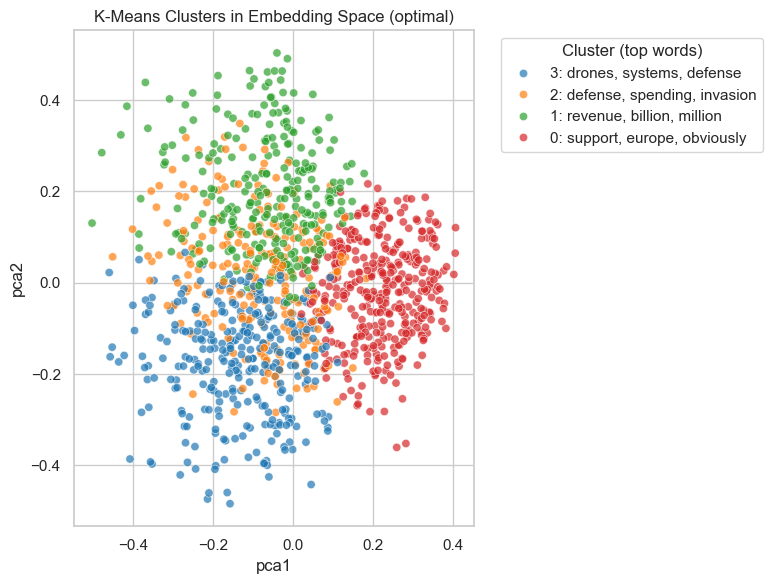


--- Visualizing LDA topic frequencies ---


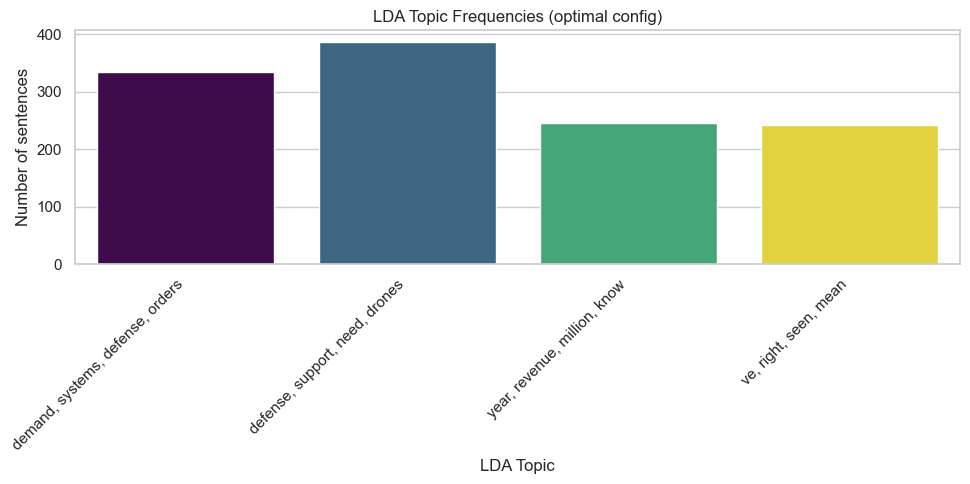


--- Visualizing BERTopic topic frequencies (Top N, optimal) ---


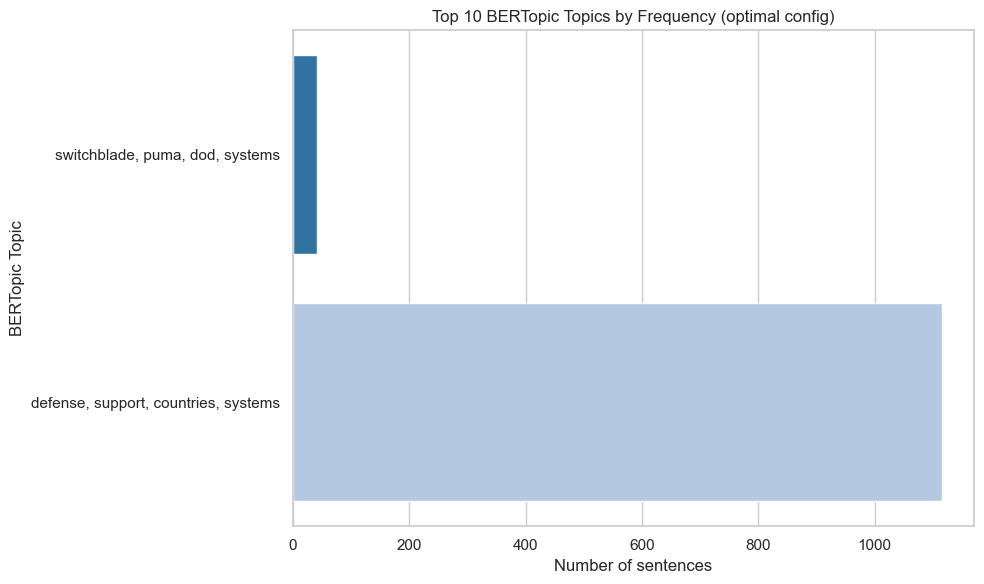


--- KMeans topics over time (by year) ---


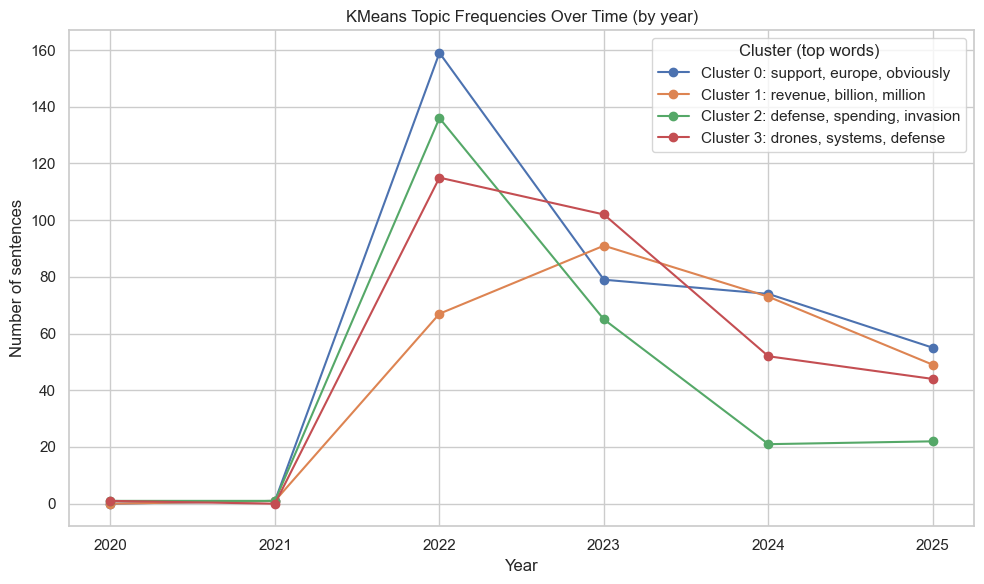

In [12]:
# ================== Topic Modeling Pipeline ==================

# ---------------------
# CONFIG
# ---------------------
TEXT_COL = "sentence"
TIME_COL = "date"

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
N_LDA_TOP_WORDS = 10
N_STABILITY_RUNS = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Grids (KMeans/LDA: 4–12; BERTopic: varied for smaller corpus)
KMEANS_K_GRID = [4, 6, 8, 10, 12]
LDA_K_GRID    = [4, 6, 8, 10, 12]

BERTOPIC_GRID = [
    {"min_topic_size":  5, "n_neighbors": 10, "min_dist": 0.4},
    {"min_topic_size": 10, "n_neighbors": 10, "min_dist": 0.3},
    {"min_topic_size": 15, "n_neighbors": 12, "min_dist": 0.2},
    {"min_topic_size": 20, "n_neighbors": 15, "min_dist": 0.1},
    {"min_topic_size": 25, "n_neighbors": 20, "min_dist": 0.05},
]

sns.set(style="whitegrid")

# Stopwords for *all* topic labels (including BERTopic vectorizer)
CUSTOM_STOPWORDS = {
    "ukraine", "russia", "russian", "war", "conflict",
    "like", "yes", "no", "one", "two", "three", "many",
    "also", "well", "think", "said", "say", "going",
    "get", "got", "still", "really"
}
STOPWORDS = set(ENGLISH_STOP_WORDS) | CUSTOM_STOPWORDS

def filter_stopwords(words):
    filtered = [w for w in words if str(w).lower() not in STOPWORDS]
    # If everything gets filtered, fall back to original words
    return filtered if filtered else [str(w) for w in words]

# ---------------------------------------
# DATA PREP
# ---------------------------------------
df = df_ukraine.copy()
df = df.dropna(subset=[TEXT_COL]).reset_index(drop=True)

if TIME_COL not in df.columns:
    df[TIME_COL] = pd.date_range("2016-01-01", periods=len(df), freq="D")

df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df = df.dropna(subset=[TIME_COL]).reset_index(drop=True)

print(f"Corpus size: {len(df):,} rows")
print("Time range:", df[TIME_COL].min(), "→", df[TIME_COL].max())

docs = df[TEXT_COL].astype(str).tolist()
timestamps = df[TIME_COL].tolist()

# ----------------------------------
# SENTENCE EMBEDDINGS
# ----------------------------------
def generate_embeddings(texts, model_name, device):
    print(f"\n--- Generating embeddings with {model_name} ---")
    model = SentenceTransformer(model_name, device=device)
    emb = model.encode(
        texts,
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True,
    )
    print("Embeddings shape:", emb.shape)
    return emb

embeddings = generate_embeddings(docs, EMBEDDING_MODEL, device)

# --------------------------------------
# COHERENCE & DIVERSITY HELPERS
# --------------------------------------
def compute_coherence_gensim(texts, topic_words, coherence_type="c_v"):
    """
    Robust coherence computation:
    - Ensures topic_words is a list of list[str]
    - Skips empty / malformed topics
    - If anything fails, returns 0.0 *without printing warnings*
    """
    if not topic_words:
        return 0.0

    topic_words_clean = []
    for tw in topic_words:
        if not isinstance(tw, (list, tuple, set)):
            continue
        words = [str(w) for w in tw if str(w).strip()]
        if words:
            topic_words_clean.append(words)

    if not topic_words_clean:
        return 0.0

    tokenized = [str(t).split() for t in texts]
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(t) for t in tokenized]

    try:
        cm = CoherenceModel(
            topics=topic_words_clean,
            texts=tokenized,
            corpus=corpus,
            dictionary=dictionary,
            coherence=coherence_type,
        )
        return cm.get_coherence()
    except Exception:
        return 0.0

def calculate_topic_diversity(topic_words, metric="cosine"):
    if not topic_words:
        return 0.0
    vocab = sorted({w for words in topic_words for w in words})
    if len(vocab) == 0:
        return 0.0
    vocab_map = {w: i for i, w in enumerate(vocab)}

    topic_vecs = []
    for words in topic_words:
        v = np.zeros(len(vocab))
        for w in words:
            v[vocab_map[w]] = 1
        topic_vecs.append(v)

    if len(topic_vecs) < 2:
        return 0.0

    if metric == "cosine":
        sims = cosine_similarity(topic_vecs)
        upper = sims[np.triu_indices(len(topic_vecs), 1)]
        return float(upper.mean())

    if metric == "jsd":
        probs = [v / max(v.sum(), 1e-9) for v in topic_vecs]
        jsd_vals = []
        for i in range(len(probs)):
            for j in range(i + 1, len(probs)):
                jsd_vals.append(jensenshannon(probs[i], probs[j]))
        return float(np.mean(jsd_vals))

    return 0.0

# ---------------------------------------
# COMPONENTS FOR OPTIMIZATION
# ---------------------------------------

# KMeans topic words from TF-IDF
def run_kmeans_topic_words(texts, embeddings, n_clusters, n_top_words=10):
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = km.fit_predict(embeddings)

    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(texts)
    vocab = vectorizer.get_feature_names_out()

    topic_words = []
    for cluster_id in range(n_clusters):
        idx = np.where(labels == cluster_id)[0]
        if len(idx) == 0:
            topic_words.append([])
            continue
        centroid = np.asarray(X[idx].mean(axis=0)).ravel()
        top_indices = centroid.argsort()[-n_top_words:][::-1]
        raw_words = [vocab[t] for t in top_indices]
        topic_words.append(filter_stopwords(raw_words))

    return labels, topic_words

# LDA (for grid)
def run_lda_grid(texts, n_topics, n_top_words, random_state=42):
    vectorizer = CountVectorizer(
        stop_words="english",
        max_df=0.90,
        min_df=2,
    )
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=random_state,
        max_iter=20,
        learning_method="online",
    )
    lda.fit(X)
    return lda, vectorizer

def get_lda_top_words(lda, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    topic_words = []
    for comp in lda.components_:
        idx = comp.argsort()[-n_top_words:][::-1]
        raw_words = [feature_names[i] for i in idx]
        topic_words.append(filter_stopwords(raw_words))
    return topic_words

# BERTopic (for grid) – with custom stopword-aware vectorizer
def run_bertopic_grid(texts, timestamps, hp, embeddings, random_state=42):

    umap_model = UMAP(
        n_neighbors=hp["n_neighbors"],
        n_components=5,
        min_dist=hp["min_dist"],
        metric="cosine",
        random_state=random_state,
    )

    hdb = HDBSCAN(
        min_cluster_size=hp["min_topic_size"],
        min_samples=5,
        prediction_data=True,
    )

    # Stopword-aware vectorizer for BERTopic’s internal c-TF-IDF
    vectorizer_model = CountVectorizer(stop_words=list(STOPWORDS))

    model = BERTopic(
        embedding_model=None,
        umap_model=umap_model,
        hdbscan_model=hdb,
        min_topic_size=hp["min_topic_size"],
        vectorizer_model=vectorizer_model,
        verbose=False,
    )

    topics, probs = model.fit_transform(texts, embeddings)
    return model, topics

def ber_topic_words(model, n_top_words=10):
    topic_words = []
    for t in model.get_topics().keys():
        if t == -1:
            continue
        raw_words = [w for w, _ in model.get_topic(t)[:n_top_words]]
        topic_words.append(filter_stopwords(raw_words))
    return topic_words

# -------------------------------
# PARAMETER OPTIMIZATION
# -------------------------------
def run_parameter_optimization(model_type, runs, texts, timestamps, hp_grid):

    results = []
    print(f"\n#### OPTIMIZING {model_type} #####")

    for hp in hp_grid:
        config_id = "_".join([f"{k}={v}" for k, v in hp.items()])
        print("\nTesting config:", config_id)

        for r in range(1, runs + 1):
            seed = 1000 + r

            if model_type == "KMeans":
                labels, topic_words = run_kmeans_topic_words(
                    texts, embeddings, hp["n_clusters"], N_LDA_TOP_WORDS
                )
                coherence = compute_coherence_gensim(texts, topic_words, "c_v")
                umass    = compute_coherence_gensim(texts, topic_words, "u_mass")
                cos_sim  = calculate_topic_diversity(topic_words, "cosine")
                jsd      = calculate_topic_diversity(topic_words, "jsd")

                results.append({
                    "model": "KMeans",
                    "config_id": config_id,
                    "run": r,
                    "n_topics": hp["n_clusters"],
                    "C_v": coherence,
                    "C_umass": umass,
                    "Avg_Cos_Sim": cos_sim,
                    "Avg_JSD": jsd,
                })

            elif model_type == "LDA":
                lda, vect = run_lda_grid(
                    texts, hp["n_topics"], N_LDA_TOP_WORDS, seed
                )
                topic_words = get_lda_top_words(lda, vect, N_LDA_TOP_WORDS)

                coherence = compute_coherence_gensim(texts, topic_words, "c_v")
                umass    = compute_coherence_gensim(texts, topic_words, "u_mass")
                cos_sim  = calculate_topic_diversity(topic_words, "cosine")
                jsd      = calculate_topic_diversity(topic_words, "jsd")

                results.append({
                    "model": "LDA",
                    "config_id": config_id,
                    "run": r,
                    "n_topics": hp["n_topics"],
                    "C_v": coherence,
                    "C_umass": umass,
                    "Avg_Cos_Sim": cos_sim,
                    "Avg_JSD": jsd,
                })

            elif model_type == "BERTopic":
                model, topics = run_bertopic_grid(
                    texts, timestamps, hp, embeddings, seed
                )
                topic_words = ber_topic_words(model, N_LDA_TOP_WORDS)

                # Now actually compute coherence, but fail-safe to 0.0
                coherence = compute_coherence_gensim(texts, topic_words, "c_v")
                umass    = compute_coherence_gensim(texts, topic_words, "u_mass")
                cos_sim  = calculate_topic_diversity(topic_words, "cosine")
                jsd      = calculate_topic_diversity(topic_words, "jsd")

                n_valid_topics = max(len(model.get_topics().keys()) - 1, 0)

                results.append({
                    "model": "BERTopic",
                    "config_id": config_id,
                    "run": r,
                    "n_topics": n_valid_topics,
                    "C_v": coherence,
                    "C_umass": umass,
                    "Avg_Cos_Sim": cos_sim,
                    "Avg_JSD": jsd,
                })

    return pd.DataFrame(results)

kmeans_grid   = [{"n_clusters": k} for k in KMEANS_K_GRID]
lda_grid      = [{"n_topics":   k} for k in LDA_K_GRID]
bertopic_grid = BERTOPIC_GRID

kmeans_results   = run_parameter_optimization("KMeans",   N_STABILITY_RUNS, docs, timestamps, kmeans_grid)
lda_results      = run_parameter_optimization("LDA",      N_STABILITY_RUNS, docs, timestamps, lda_grid)
bertopic_results = run_parameter_optimization("BERTopic", N_STABILITY_RUNS, docs, timestamps, bertopic_grid)

all_results = pd.concat([kmeans_results, lda_results, bertopic_results], ignore_index=True)

# ---------------------------
# SUMMARIZE
# ---------------------------
def summarize_and_pick_best(results):

    summary = results.groupby(["model", "config_id"]).agg({
        "n_topics":     ["mean"],
        "C_v":          ["mean"],
        "C_umass":      ["mean"],
        "Avg_Cos_Sim":  ["mean"],
        "Avg_JSD":      ["mean"],
    })

    summary.columns = ["_".join(c) for c in summary.columns]
    summary["Diversity_Proxy"] = 1 - summary["Avg_Cos_Sim_mean"]

    print("\n### OPTIMIZATION SUMMARY ###")
    print(summary)

    best_params = {}

    for model_name in ["KMeans", "LDA", "BERTopic"]:
        sub = summary.loc[(model_name,)]

        if model_name in ["KMeans", "LDA"]:
            # Use coherence first, then diversity
            sub_ranked = sub.sort_values(
                ["C_v_mean", "Diversity_Proxy"], ascending=False
            )
        else:
            # For BERTopic: drop configs that collapse to <= 2 topics
            sub = sub[sub["n_topics_mean"] > 2]
            sub_ranked = sub.sort_values(
                ["C_v_mean", "Diversity_Proxy"], ascending=False
            )

        best_config_id = sub_ranked.index[0]
        best_row = sub_ranked.loc[best_config_id]
        if model_name in ["KMeans", "LDA"]:
            best_k = int(round(best_row["n_topics_mean"]))
            best_params[model_name] = {"n_topics": best_k}
        else:
            best_params[model_name] = {"config_id": best_config_id}

        print(f"\nBest config for {model_name}: {best_config_id}")
        print(best_row[[
            "n_topics_mean",
            "C_v_mean",
            "C_umass_mean",
            "Avg_Cos_Sim_mean",
            "Avg_JSD_mean",
            "Diversity_Proxy",
        ]])

    # Best overall model by C_v_mean
    best_overall_idx = summary["C_v_mean"].idxmax()
    best_overall_model = best_overall_idx[0]
    best_overall_config = best_overall_idx[1]
    print(f"\n*** Best overall model: {best_overall_model} with config {best_overall_config} ***")

    return summary, best_params, best_overall_model, best_overall_config

summary, best_params, best_overall_model, best_overall_config = summarize_and_pick_best(all_results)

def parse_bertopic_config_id(config_id):
    hp = {}
    for p in config_id.split("_"):
        if "=" not in p:
            continue
        k, v = p.split("=", 1)
        try:
            v_parsed = int(v)
        except ValueError:
            try:
                v_parsed = float(v)
            except ValueError:
                v_parsed = v
        hp[k] = v_parsed
    return hp

best_kmeans_hp   = {"n_clusters": best_params["KMeans"]["n_topics"]}
best_lda_hp      = {"n_topics":   best_params["LDA"]["n_topics"]}
best_bertopic_hp = parse_bertopic_config_id(best_params["BERTopic"]["config_id"])

print("\nBest KMeans hyperparams:",   best_kmeans_hp)
print("Best LDA hyperparams:",       best_lda_hp)
print("Best BERTopic hyperparams:",  best_bertopic_hp)
print("Best overall topic model family:", best_overall_model)

# ---------------------------------------------------------------------------
# BASELINE MODELS USING OPTIMAL CONFIGS
# ---------------------------------------------------------------------------

# KMeans baseline
def run_kmeans_baseline(embeddings, hp):
    k = hp["n_clusters"]
    print(f"\n--- Baseline KMeans with optimal K={k} ---")
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(embeddings)
    return km, labels

kmeans_model, kmeans_labels = run_kmeans_baseline(embeddings, best_kmeans_hp)
df["kmeans_cluster"] = kmeans_labels

def build_kmeans_topic_labels(texts, labels, n_clusters, n_top_words=10):
    """
    Compute top TF-IDF words per KMeans cluster and return a dict:
        cluster_id -> "w1, w2, w3"
    with stopwords removed via `filter_stopwords`.
    """
    # TF-IDF over the full corpus (same as in run_kmeans_topic_words)
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(texts)
    vocab = vectorizer.get_feature_names_out()

    topic_labels = {}
    for cluster_id in range(n_clusters):
        idx = np.where(labels == cluster_id)[0]
        if len(idx) == 0:
            topic_labels[cluster_id] = f"{cluster_id}"
            continue

        # Average TF-IDF within cluster
        centroid = np.asarray(X[idx].mean(axis=0)).ravel()
        top_indices = centroid.argsort()[-n_top_words:][::-1]
        raw_words = [vocab[t] for t in top_indices]
        clean_words = filter_stopwords(raw_words)

        # Use first 3 descriptive words
        top3 = clean_words[:3] if clean_words else raw_words[:3]
        topic_labels[cluster_id] = ", ".join(top3)

    return topic_labels

kmeans_topic_labels = build_kmeans_topic_labels(
    texts=docs,
    labels=kmeans_labels,
    n_clusters=best_kmeans_hp["n_clusters"],
    n_top_words=N_LDA_TOP_WORDS,
)

# LDA baseline
def run_lda_baseline(texts, hp, n_top_words):
    k = hp["n_topics"]
    print(f"\n--- Baseline LDA with optimal n_topics={k} ---")
    vectorizer = CountVectorizer(
        stop_words="english",
        max_df=0.90,
        min_df=2,
    )
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        max_iter=20,
        learning_method="online",
    )
    lda.fit(X)
    doc_topic = lda.transform(X)  # N x k probabilities
    doc_topic_ids = np.argmax(doc_topic, axis=1)
    feature_names = vectorizer.get_feature_names_out()

    topic_labels = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        raw_words = [feature_names[i] for i in top_indices]
        clean_words = filter_stopwords(raw_words)
        label = ", ".join(clean_words[:4])
        topic_labels[topic_idx] = label

    print("\nBaseline LDA topics (top words):")
    for tid, label in topic_labels.items():
        print(f"  Topic {tid}: {label}")

    return lda, vectorizer, doc_topic_ids, topic_labels, doc_topic

lda_model, lda_vectorizer, lda_topic_ids, lda_topic_labels, lda_doc_topic = run_lda_baseline(
    docs, best_lda_hp, N_LDA_TOP_WORDS
)
df["lda_topic"] = lda_topic_ids

# BERTopic baseline
def run_bertopic_baseline(texts, timestamps, embeddings, hp):
    min_topic_size = hp.get("min_topic_size", 10)
    n_neighbors    = hp.get("n_neighbors", 10)
    min_dist       = hp.get("min_dist", 0.3)

    print("\n--- Baseline BERTopic with hyperparams ---")
    print(f"  min_topic_size = {min_topic_size}")
    print(f"  n_neighbors    = {n_neighbors}")
    print(f"  min_dist       = {min_dist}")

    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=5,
        min_dist=min_dist,
        metric="cosine",
        random_state=42,
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=min_topic_size,
        min_samples=5,
        prediction_data=True,
    )

    vectorizer_model = CountVectorizer(stop_words=list(STOPWORDS))

    topic_model = BERTopic(
        embedding_model=None,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size,
        vectorizer_model=vectorizer_model,
        verbose=False,
    )

    topics, probs = topic_model.fit_transform(texts, embeddings)
    print("Baseline BERTopic unique topics (incl. -1):", sorted(set(topics)))

    return topic_model, topics, probs

print("\n[DEBUG] best_bertopic_hp:", best_bertopic_hp)
topic_model, bertopic_topics, bertopic_probs = run_bertopic_baseline(
    docs, timestamps, embeddings, best_bertopic_hp)
df["bertopic_topic"] = bertopic_topics

def label_bertopic_topics(topic_model, n_words=10):
    topic_labels = {}
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:
            continue
        raw_words = [w for w, _ in topic_model.get_topic(topic_id)[:n_words]]
        clean_words = filter_stopwords(raw_words)
        topic_labels[topic_id] = ", ".join(clean_words[:4])
    print("\nBaseline BERTopic topics (top words):")
    for tid, label in topic_labels.items():
        print(f"  Topic {tid}: {label}")
    return topic_labels

bertopic_topic_labels = label_bertopic_topics(topic_model)

# ---------------------------------------------------------------------------
# ATTACH LABELS + BEST OVERALL TOPIC INFO
# ---------------------------------------------------------------------------

df["lda_topic_label"]      = df["lda_topic"].map(lda_topic_labels)
df["bertopic_topic_label"] = df["bertopic_topic"].map(bertopic_topic_labels)

# --- Best overall model topic id + probability per document ---
df["topic_model_best"] = best_overall_model
df["topic_id_best"]    = np.nan
df["topic_prob_best"]  = np.nan

if best_overall_model == "KMeans":
    distances = kmeans_model.transform(embeddings)  # N x K
    # similarity: higher when closer
    sim = 1.0 / (1.0 + distances)
    # softmax over clusters
    sim_exp = np.exp(sim - sim.max(axis=1, keepdims=True))
    probs_k = sim_exp / sim_exp.sum(axis=1, keepdims=True)
    max_prob = probs_k[np.arange(len(df)), kmeans_labels]

    df["topic_id_best"]   = df["kmeans_cluster"]
    df["topic_prob_best"] = max_prob

elif best_overall_model == "LDA":
    max_prob = lda_doc_topic.max(axis=1)
    df["topic_id_best"]   = df["lda_topic"]
    df["topic_prob_best"] = max_prob

elif best_overall_model == "BERTopic":
    # bertopic_probs: N x T; just take max probability
    max_prob = bertopic_probs.max(axis=1)
    df["topic_id_best"]   = df["bertopic_topic"]
    df["topic_prob_best"] = max_prob

print("\nSample of annotated data (optimal configs + best overall topic info):")
print(
    df[[TEXT_COL,
        "kmeans_cluster",
        "lda_topic_label",
        "bertopic_topic_label",
        "topic_model_best",
        "topic_id_best",
        "topic_prob_best"]]
    .head(10)
    .to_string()
)

# ---------------------------------------------------------------------------
# VISUALIZATIONS (USING OPTIMAL BASELINE MODELS)
# ---------------------------------------------------------------------------

def plot_kmeans_pca(embeddings, labels, topic_labels, title_suffix="(optimal)"):
    """
    PCA scatter of KMeans clusters, with legend entries:
        <cluster_id>: w1, w2, w3
    using the same stopword-filtered labels as elsewhere.
    """
    print("\n--- Visualizing KMeans clusters (PCA) ---")
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(embeddings)

    # Map cluster -> human-readable label
    def cluster_to_label(c):
        words = topic_labels.get(c, "")
        return f"{c}: {words}" if words else f"{c}"

    df_plot = pd.DataFrame({
        "pca1": coords[:, 0],
        "pca2": coords[:, 1],
        "cluster": labels,
    })
    df_plot["cluster_label"] = df_plot["cluster"].map(cluster_to_label)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_plot,
        x="pca1",
        y="pca2",
        hue="cluster_label",
        palette="tab10",
        alpha=0.7,
    )
    plt.title(f"K-Means Clusters in Embedding Space {title_suffix}")
    plt.legend(title="Cluster (top words)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


plot_kmeans_pca(embeddings, kmeans_labels, kmeans_topic_labels)

def plot_lda_topic_counts(topic_ids, topic_labels):
    print("\n--- Visualizing LDA topic frequencies ---")
    counts = pd.Series(topic_ids).value_counts().sort_index()
    labels = [topic_labels.get(tid, str(tid)) for tid in counts.index]

    num_topics = len(counts)
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(range(num_topics)), y=counts.values, palette=colors)
    plt.xticks(range(num_topics), labels, rotation=45, ha="right")
    plt.xlabel("LDA Topic")
    plt.ylabel("Number of sentences")
    plt.title("LDA Topic Frequencies (optimal config)")
    plt.tight_layout()
    plt.show()

plot_lda_topic_counts(lda_topic_ids, lda_topic_labels)

def plot_bertopic_topic_counts(topics, topic_labels, top_n=10):
    print("\n--- Visualizing BERTopic topic frequencies (Top N, optimal) ---")
    s = pd.Series(topics)
    s = s[s != -1]
    if s.empty:
        print("All documents assigned to topic -1; no valid BERTopic topics to plot.")
        return

    counts = s.value_counts().head(top_n).sort_values(ascending=True)
    labels = [topic_labels.get(tid, str(tid)) for tid in counts.index]

    palette = sns.color_palette("tab20", n_colors=len(counts))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.values, y=labels, orient="h", palette=palette)
    plt.xlabel("Number of sentences")
    plt.ylabel("BERTopic Topic")
    plt.title(f"Top {top_n} BERTopic Topics by Frequency (optimal config)")
    plt.tight_layout()
    plt.show()

plot_bertopic_topic_counts(bertopic_topics, bertopic_topic_labels)

# ---------------------------------------------------------------------------
# KMEANS TOPICS OVER TIME (optimal overall topic model)
# ---------------------------------------------------------------------------

def plot_kmeans_topics_over_time(
    df,
    topic_labels,
    time_col=TIME_COL,
    cluster_col="kmeans_cluster"
):
    """
    KMeans topic frequencies over time, with legend entries:
        Cluster <id>: w1, w2, w3
    where w1–w3 are top TF-IDF words after stopword filtering.
    """
    print("\n--- KMeans topics over time (by year) ---")
    df_time = df[[time_col, cluster_col]].copy()
    df_time["year"] = df_time[time_col].dt.year

    counts = (
        df_time
        .groupby(["year", cluster_col])
        .size()
        .reset_index(name="count")
    )

    pivot = counts.pivot(index="year", columns=cluster_col, values="count").fillna(0)

    plt.figure(figsize=(10, 6))
    for cl in pivot.columns:
        words = topic_labels.get(cl, "")
        label = f"Cluster {cl}: {words}" if words else f"Cluster {cl}"
        plt.plot(pivot.index, pivot[cl], marker="o", label=label)

    plt.xlabel("Year")
    plt.ylabel("Number of sentences")
    plt.title("KMeans Topic Frequencies Over Time (by year)")
    plt.legend(title="Cluster (top words)")
    plt.tight_layout()
    plt.show()


plot_kmeans_topics_over_time(df, kmeans_topic_labels)


### NLI Benefit Aggregation

- Formulates **natural-language inference (NLI)** as a test for Gricean implicature:
  - Premise: earnings-call sentence.
  - Hypotheses: a small set of hand-crafted “benefit” statements capturing explicit and implicit profit from the Ukraine war / defense demand.

- Uses multiple **MNLI-trained transformer classifiers** (`roberta-large-mnli`, `facebook/bart-large-mnli`):
  - Direct model calls via `AutoTokenizer` / `AutoModelForSequenceClassification` (no zero-shot pipeline wrapper).
  - Batched inference with optional mixed-precision (AMP) on GPU.
  - Extracts entailment / neutral / contradiction probabilities for each (sentence, hypothesis, model) triplet.

- Aggregates NLI scores across models at the **hypothesis level**:
  - For each benefit hypothesis, averages entailment probabilities over all MNLI models.
  - Builds a hypothesis-score matrix per sentence (rows = sentences, columns = benefit hypotheses).

- Computes **sentence-level NLI summary scores** across benefit hypotheses:
  - Mean entailment across all benefit hypotheses.
  - Max entailment across all benefit hypotheses (strongest single-benefit signal).

- Implements a **data-driven dominance test** for aggregation choice:
  - Identifies, among rows with nontrivial entailment, which hypothesis is most often the argmax.
  - Computes the dominance share of each hypothesis (fraction of “max” assignments).
  - If one hypothesis is “too dominant” (dominance share above a threshold), defines the final score as that hypothesis’ entailment only.
  - Otherwise, defines the final score as the max entailment over all benefit hypotheses.

In [17]:
# ===========================================================
# NLI for Gricean Implicature
# ===========================================================

df = df

# Merge keys for optional labeled diagnostics
if set(["file", "sentence_id"]).issubset(df.columns):
    MERGE_KEYS = ["file", "sentence_id"]
else:
    MERGE_KEYS = ["sentence"]

# Models: solid public MNLI models (fast + accurate)
MODEL_IDS = [
    "roberta-large-mnli",
    "facebook/bart-large-mnli",
]

# Benefit hypotheses (explicit + implicit), phrased to capture war-driven benefit
H_BENEFIT = {
    "A_explicit": "The company’s positive financial performance is a direct or indirect result of the war in Ukraine or increased defense spending.",
    "B_implicit": "The company benefits from increased orders or demand because of the war in Ukraine or increased defense activity.",
    "C_opportunities": "The company profits from new business opportunities arising from the Russian invasion of Ukraine.",
    "D_military_demand": "The company profits from increased military spending and higher product demand following the Ukraine war.",
}

# Dominance logic for aggregation choice
DOMINANCE_SHARE_THRESHOLD = 0.80   # "too dominant" if one hypothesis is max in ≥ 80% of high-score rows
DOMINANCE_MIN_SCORE = 0.05         # only consider rows with at least this entailment level

# Device / AMP
device = torch.device("cuda" if torch.cuda.is_available() else
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
use_autocast = torch.cuda.is_available()
dtype_autocast = torch.float16

# Dynamic batch size
BATCH_SIZE = 32 if torch.cuda.is_available() else 8
MAX_LENGTH = 256

sentences      = df["sentence"].astype(str).tolist()
sentences_prev = df["sentence_prev"].astype(str).tolist()

# -------------------
# Utilities
# -------------------
def get_label_index(config, label_name: str) -> int:
    """Return index of a label in model config, case-insensitive."""
    id2label = getattr(config, "id2label", None)
    if isinstance(id2label, dict) and len(id2label) > 0:
        for i, lab in id2label.items():
            if str(lab).strip().lower() == label_name:
                return int(i)
    label2id = getattr(config, "label2id", None)
    if isinstance(label2id, dict) and len(label2id) > 0:
        for lab, i in label2id.items():
            if str(lab).strip().lower() == label_name:
                return int(i)
    defaults = {"contradiction":0, "neutral":1, "entailment":2}
    return defaults[label_name]

def batched(iterable, n):
    it = iter(iterable)
    while True:
        buf = []
        try:
            for _ in range(n):
                buf.append(next(it))
        except StopIteration:
            if buf:
                yield buf
            break
        yield buf

def score_model(model_id: str,
                sents: list,
                hypotheses: dict,
                batch_size: int = 32,
                max_length: int = 256):
    """
    Return dict of DataFrames with NLI scores per hypothesis for a given model.
    Each DF has columns: <short>_<hyp_key>_ent/neu/con
    """
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_id).to(device).eval()
    ent_idx = get_label_index(mdl.config, "entailment")
    neu_idx = get_label_index(mdl.config, "neutral")
    con_idx = get_label_index(mdl.config, "contradiction")

    outputs = {hkey: {"ent": [], "neu": [], "con": []} for hkey in hypotheses.keys()}

    for batch in tqdm(batched(iter(sents), batch_size),
                      total=math.ceil(len(sents)/batch_size),
                      desc=f"NLI {model_id.split('/')[-1]}"):
        for hkey, hyp in hypotheses.items():
            enc = tok(
                batch,
                [hyp]*len(batch),
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            with torch.no_grad():
                if use_autocast:
                    with torch.autocast(device_type="cuda", dtype=dtype_autocast):
                        logits = mdl(**{k: v.to(device) for k, v in enc.items()}).logits
                else:
                    logits = mdl(**{k: v.to(device) for k, v in enc.items()}).logits
                probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
            outputs[hkey]["ent"].extend(probs[:, ent_idx].tolist())
            outputs[hkey]["neu"].extend(probs[:, neu_idx].tolist())
            outputs[hkey]["con"].extend(probs[:, con_idx].tolist())

        del enc, logits
        gc.collect()

    dfs = {}
    short = model_id.split("/")[-1]
    for hkey in hypotheses.keys():
        dfs[hkey] = pd.DataFrame({
            f"{short}_{hkey}_ent": outputs[hkey]["ent"],
            f"{short}_{hkey}_neu": outputs[hkey]["neu"],
            f"{short}_{hkey}_con": outputs[hkey]["con"],
        })
    return dfs

# -------------------
# Run all models × hypotheses
# -------------------
all_frames = [df.reset_index(drop=True)]

for mid in MODEL_IDS:
    # Benefit hypotheses on CURRENT sentences
    dfs_benefit = score_model(
        model_id=mid,
        sents=sentences,
        hypotheses=H_BENEFIT,
        batch_size=BATCH_SIZE,
        max_length=MAX_LENGTH
    )
    for dframe in dfs_benefit.values():
        all_frames.append(dframe.reset_index(drop=True))

res = pd.concat(all_frames, axis=1)

# -------------------
# Aggregations & consensus
# -------------------
# 1) Average entailment across models per benefit hypothesis
for hkey in H_BENEFIT.keys():
    ent_cols = [c for c in res.columns if c.endswith(f"{hkey}_ent")]
    res[f"agg_{hkey}_ent"] = res[ent_cols].mean(axis=1).astype(float) if ent_cols else np.nan

# 2) Build matrix of benefit hypothesis scores
benef_ent_cols = [f"agg_{hkey}_ent" for hkey in H_BENEFIT.keys()]
benef_mat = res[benef_ent_cols].to_numpy(dtype=float)

# 3) Compute mean and max aggregates across benefit hypotheses
res["agg_nli_entailment_mean"] = np.nanmean(benef_mat, axis=1)
res["agg_nli_entailment_max"]  = np.nanmax(benef_mat, axis=1)

# 4) Dominance analysis: is one hypothesis "too dominant"?
with np.errstate(invalid="ignore"):
    row_max = np.nanmax(benef_mat, axis=1)
valid_mask = np.isfinite(row_max) & (row_max >= DOMINANCE_MIN_SCORE)

dominance_shares = {}
dominant_hypothesis = None
dominance_share_max = np.nan
agg_strategy = None

if valid_mask.any():
    idx_max = np.nanargmax(benef_mat[valid_mask, :], axis=1)  # index of max hyp per row
    total_valid = float(valid_mask.sum())
    for j, col in enumerate(benef_ent_cols):
        share = float((idx_max == j).sum()) / total_valid
        dominance_shares[col] = share

    # Determine most dominant hypothesis and its share
    dominant_hypothesis = max(dominance_shares, key=dominance_shares.get)
    dominance_share_max = dominance_shares[dominant_hypothesis]

    # Strategy: if dominance is too high → use that single hypothesis; else → use max across hypotheses
    if dominance_share_max >= DOMINANCE_SHARE_THRESHOLD:
        agg_strategy = "single_hypothesis"
        res["agg_nli_entailment"] = res[dominant_hypothesis].astype(float)
    else:
        agg_strategy = "max_over_hypotheses"
        res["agg_nli_entailment"] = res["agg_nli_entailment_max"].astype(float)
else:
    # Fallback: if nothing qualifies, use max
    agg_strategy = "max_over_hypotheses_fallback"
    res["agg_nli_entailment"] = res["agg_nli_entailment_max"].astype(float)

# -------------------
# Hypothesis diagnostics (dominance & distributions)
# -------------------
nli_dir = output_dir / "nli_implicature"
nli_dir.mkdir(parents=True, exist_ok=True)
hyp_dir = nli_dir / "hypothesis_diagnostics"
hyp_dir.mkdir(parents=True, exist_ok=True)

# 1) Dominance shares table + barplot (which hypothesis is max most often?)
dom_rows = []
for col in benef_ent_cols:
    dom_rows.append({
        "hypothesis_col": col,
        "dominance_share_among_valid": dominance_shares.get(col, 0.0)
    })
dom_df = pd.DataFrame(dom_rows).sort_values("dominance_share_among_valid", ascending=False)
dom_path = hyp_dir / "benefit_hypothesis_dominance_shares.csv"
dom_df.to_csv(dom_path, index=False)

plt.figure(figsize=(7, 4), dpi=140)
plt.bar(dom_df["hypothesis_col"], dom_df["dominance_share_among_valid"])
plt.ylabel("Share of rows with max entailment\n(among rows with entailment ≥ 0.05)")
plt.xticks(rotation=30, ha="right")
plt.title("Dominance of Benefit Hypotheses")
plt.tight_layout()
plt.savefig(hyp_dir / "dominance_shares_barplot.png")
plt.close()

# 2) Distribution / overlap of hypothesis scores (overall)
max_score = float(np.nanmax(benef_mat)) if np.isfinite(benef_mat).any() else 0.0
if max_score > 0:
    bins = np.linspace(0.0, max(0.8, max_score), 80)

    plt.figure(figsize=(8, 4.5), dpi=140)
    for col in benef_ent_cols:
        vals = res[col].astype(float)
        vals = vals[np.isfinite(vals)]
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=bins, density=True, histtype="step", label=col)
    plt.xlabel("Entailment probability")
    plt.ylabel("Density")
    plt.title("Distributions of Benefit Hypothesis Entailment Scores (Overall)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(hyp_dir / "benefit_hypotheses_distributions_overall.png")
    plt.close()

    # 3) Distributions conditional on high final NLI score (choose 0.15 as cut-off)
    mask_high = res["agg_nli_entailment"] >= 0.15
    if mask_high.any():
        plt.figure(figsize=(8, 4.5), dpi=140)
        for col in benef_ent_cols:
            vals = res.loc[mask_high, col].astype(float)
            vals = vals[np.isfinite(vals)]
            if len(vals) == 0:
                continue
            plt.hist(vals, bins=bins, density=True, histtype="step", label=col)
        plt.xlabel("Entailment probability")
        plt.ylabel("Density")
        plt.title(f"Benefit Hypothesis Distributions\nConditional on agg_nli_entailment ≥ {0.15:.2f}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(hyp_dir / "benefit_hypotheses_distributions_high_nli.png")
        plt.close()

# -------------------
# Save main artifacts
# -------------------
# Full NLI table
full_path = nli_dir / "nli_scores.csv"
res.to_csv(full_path, index=False)

# Top sentences by final aggregated benefit entailment
top_k = 60
top_cols = [c for c in [
    "file","sentence_id","speaker","section","date","topic_id","topic_prob",
    "sentence_prev","sentence","sentence_next",
    "agg_nli_entailment",
] if c in res.columns]

top_nli = (res[top_cols]
           .sort_values("agg_nli_entailment", ascending=False)
           .head(top_k)
           .reset_index(drop=True))
top_path = nli_dir / "top_sentences_nli.csv"
top_nli.to_csv(top_path, index=False)

# Diagnostics: basic stats + aggregation strategy info
diag = {}
diag["n_total"] = int(len(res))
diag["mean_agg_ent_final"] = float(res["agg_nli_entailment"].mean())
diag["aggregation_strategy"] = agg_strategy
diag["dominance_threshold_share"] = DOMINANCE_SHARE_THRESHOLD
diag["dominance_min_score"] = DOMINANCE_MIN_SCORE
diag["dominance_shares"] = dominance_shares
diag["dominant_hypothesis"] = dominant_hypothesis
diag["dominant_hypothesis_share"] = dominance_share_max

with open(nli_dir / "nli_diagnostics.json", "w") as f:
    json.dump(diag, f, indent=2)

# -------------------
# Minimal plot for final agg score
# -------------------
plt.figure(figsize=(7,4), dpi=140)
plt.hist(res["agg_nli_entailment"], bins=40)
plt.xlabel("Final Aggregated NLI Entailment Probability (benefit hypotheses)")
plt.ylabel("Number of Sentences")
plt.title("Distribution of NLI-based Benefit/Implicature Scores")
plt.tight_layout()
plt.savefig(nli_dir / "hist_agg_nli_entailment.png"); plt.close()

# -------------------
# Console summary
# -------------------
print("=== NLI implicature (semantic-only) — run summary ===")
print(f"Rows scored: {len(res)} | Models: {', '.join(MODEL_IDS)}")
print(f"Benefit hypotheses: {', '.join(H_BENEFIT.keys())}")
print(f"Aggregation strategy: {agg_strategy}")
if dominant_hypothesis is not None:
    print(f"  Dominant hypothesis: {dominant_hypothesis} "
          f"(share among rows with entailment ≥ {DOMINANCE_MIN_SCORE:.2f}: {dominance_share_max:.1%})")
print("Saved NLI scores:", full_path)
print("Top NLI sentences:", top_path)
print("Diagnostics:", nli_dir / "nli_diagnostics.json")
print("Hypothesis diagnostics dir:", hyp_dir)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
NLI bart-large-mnli: 100%|██████████| 152/152 [01:39<00:00,  1.53it/s]


=== NLI implicature (semantic-only) — run summary ===
Rows scored: 1209 | Models: roberta-large-mnli, facebook/bart-large-mnli
Benefit hypotheses: A_explicit, B_implicit, C_opportunities, D_military_demand
Aggregation strategy: single_hypothesis
  Dominant hypothesis: agg_B_implicit_ent (share among rows with entailment ≥ 0.05: 96.5%)
Saved NLI scores: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/nli_scores.csv
Top NLI sentences: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/top_sentences_nli.csv
Diagnostics: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/nli_diagnostics.json
Hypothesis diagnostics dir: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/hypothesis_diagnostics


### NLI-only Covert Benefit Evaluation

- **Input**
  - Reads sentence-level NLI scores from `nli_implicature/nli_scores.csv`
  - Uses `agg_nli_entailment` as the core covert-benefit score

- **Core Operations**
  - Cleans NLI scores and keeps only valid numeric entries
  - Evaluates a grid of quantile thresholds (e.g. 0.80–0.95) as review budgets
  - Summarizes NLI score distribution (mean, quantiles, min/max, NA share)

- **Topic-level Analysis (optional)**
  - If `topic_id` is present:
    - Computes topic-level mean NLI scores and sentence counts
    - Exports per-topic top-NLI sentences for qualitative inspection

- **Visual Diagnostics**
  - Histogram of NLI scores (entailment probabilities)
  - Quarterly time trend of “high-NLI” sentences (above q=0.90), if `date` is available
  - Section-level boxplots of NLI scores, if `section` is available

- **Review Sets & Baselines**
  - Exports top-K sentences by NLI score (`top_sentences_nli.csv`)
  - Exports a random baseline sample of sentences (same size) for comparison

In [18]:
# ===========================================================
# Evaluation: NLI-based Covert Benefit Scoring
# ===========================================================

# -------------------
# I/O
# -------------------
nli_dir    = output_dir / "nli_implicature"
nli_path   = nli_dir / "nli_scores.csv"

if not nli_path.exists():
    raise FileNotFoundError(f"Missing NLI scores file: {nli_path}")

df = pd.read_csv(nli_path)

eval_dir = output_dir / "evaluation_nli_only"
eval_dir.mkdir(parents=True, exist_ok=True)

# -------------------
# Core score column
# -------------------
N_COL = "agg_nli_entailment"
if N_COL not in df.columns:
    raise ValueError(f"Required NLI score column '{N_COL}' missing in NLI data.")

df[N_COL] = pd.to_numeric(df[N_COL], errors="coerce")
df = df[np.isfinite(df[N_COL])].copy()
if len(df) == 0:
    raise ValueError("No rows with valid NLI scores available.")

N = df[N_COL].values

# Merge keys for later exports (if present)
if set(["file", "sentence_id"]).issubset(df.columns):
    merge_keys = ["file", "sentence_id"]
else:
    merge_keys = ["sentence"]  # fallback

# -------------------
# Quantile grid (review-budget operating points)
# -------------------
QUANTILES_GRID = [0.80, 0.85, 0.90, 0.95]
oper_rows = []

for q_hi in QUANTILES_GRID:
    thr_N = float(np.quantile(N, q_hi))
    hi_N  = N >= thr_N

    oper_rows.append({
        "q_hi": q_hi,
        "thr_nli": thr_N,
        "share_nli_high": float(hi_N.mean()),
        "n_high": int(hi_N.sum())
    })

oper_df = pd.DataFrame(oper_rows)

metrics = {
    "n_rows_scored": int(len(df)),
    "quantile_grid": QUANTILES_GRID,
}

metrics_path = eval_dir / "nli_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

oper_df_path = eval_dir / "nli_operating_points_by_quantile.csv"
oper_df.to_csv(oper_df_path, index=False)

# -------------------
# Topic-level view (if topics available)
#   - Topic-level mean NLI score, counts, and topic_prob if present
# -------------------
topic_stats_path = None
topic_top_path   = None

if "topic_id" in df.columns:
    group_cols = ["topic_id"]
    topic_means = (
        df.groupby(group_cols)
          .agg(
              n_sentences=("sentence", "size"),
              mean_nli=(N_COL, "mean"),
              mean_topic_prob=("topic_prob", "mean") if "topic_prob" in df.columns else ("file", "size")
          )
          .reset_index()
    )

    topic_stats_path = eval_dir / "topic_level_nli_means.csv"
    topic_means.to_csv(topic_stats_path, index=False)

    # Topic-specific top NLI sentences (for inspection)
    topic_top_rows = []
    for tid, sub in df.groupby("topic_id"):
        sub_top = (
            sub.sort_values(N_COL, ascending=False)
               .head(30)  # 30 per topic
               .assign(topic_id=tid)
        )
        topic_top_rows.append(sub_top)
    topic_top = pd.concat(topic_top_rows, axis=0).reset_index(drop=True)

    keep_for_topic_top = [c for c in [
        "topic_id", "topic_prob", "file", "sentence_id", "speaker", "section", "date",
        "sentence_prev", "sentence", "sentence_next",
        N_COL
    ] if c in topic_top.columns]

    topic_top_path = eval_dir / "topic_top_sentences_nli.csv"
    topic_top[keep_for_topic_top].to_csv(topic_top_path, index=False)


# 3) Section split boxplots
if "section" in df.columns:
    sec = df["section"].astype(str).str.lower()
    order = sec.value_counts().index.tolist()[:4]
    data_n = [df.loc[sec == s, N_COL].dropna().values for s in order]

    if all(len(v) > 0 for v in data_n):
        plt.figure(figsize=(6.5,4.5), dpi=140)
        plt.boxplot(data_n, labels=order, showmeans=True)
        plt.title("NLI score by Section")
        plt.ylabel("Entailment probability")
        plt.xticks(rotation=20, ha="right")
        plt.tight_layout()
        plt.savefig(eval_dir / "section_boxplots_nli.png"); plt.close()

# -------------------
# Quantitative descriptors
# -------------------
def summarize_feature(x):
    x = pd.to_numeric(x, errors="coerce")
    return {
        "mean": float(np.nanmean(x)),
        "std":  float(np.nanstd(x)),
        "p5":   float(np.nanpercentile(x, 5)),
        "p25":  float(np.nanpercentile(x, 25)),
        "median": float(np.nanpercentile(x, 50)),
        "p75":  float(np.nanpercentile(x, 75)),
        "p95":  float(np.nanpercentile(x, 95)),
        "min":  float(np.nanmin(x)),
        "max":  float(np.nanmax(x)),
        "na_share": float(np.mean(~np.isfinite(x)))
    }

rows = []
stats = summarize_feature(df[N_COL])
stats["score"] = N_COL
rows.append(stats)

stats_df = pd.DataFrame(rows).set_index("score")
stats_path = eval_dir / "nli_score_descriptives.csv"
stats_df.to_csv(stats_path)

# -------------------
# Console summary
# -------------------
print("=== NLI-only Covert Benefit Evaluation ===")
print(f"Rows scored (NLI-only): {metrics['n_rows_scored']}")
print("Quantile grid:", QUANTILES_GRID)


=== NLI-only Covert Benefit Evaluation ===
Rows scored (NLI-only): 1209
Quantile grid: [0.8, 0.85, 0.9, 0.95]


### Generate test set (only run if test set not supplied)

In [ ]:
""" import pandas as pd
import numpy as np
from pathlib import Path

# ==============================
# 0) CONFIG: adapt to your names
# ==============================
# Main sentence-level dataframe
df_main = df_ukraine  # <- change if your df is called differently

# Columns for identification and models
COL_SENTENCE = "sentence"
COL_DOC_ID   = "file"        # change or set to None if not available
COL_SENT_ID  = "sentence_id"   # change or set to None if not available

# Output path (directory + filename)
output_dir = Path("evaluation_outputs")
output_dir.mkdir(parents=True, exist_ok=True)
eval_sample_path = output_dir / "eval_sample_implicit_profit_100.csv"

# ==============================
# 1) Build base subset for sampling
# ==============================

# Drop rows with missing sentence text
df_base = df_main.dropna(subset=[COL_SENTENCE]).copy()

print(f"Sampling from {len(df_base):,} candidate sentences.")

# ==============================
# 2) Random sample of 100 sentences
# ==============================
N_SAMPLE = 100
if len(df_base) < N_SAMPLE:
    print(f"Warning: only {len(df_base)} sentences available, using all.")
    N_SAMPLE = len(df_base)

df_eval = df_base.sample(n=N_SAMPLE, random_state=42).reset_index(drop=True)

# ==============================
# 3) Add empty label columns for manual annotation
# ==============================
# Suggested scheme:
#   label_implicit: 0 = no, 1 = yes, 2 = ambiguous / unclear
#   label_notes: free text notes for your justification / comments

df_eval["label_implicit"] = pd.Series([np.nan] * len(df_eval), dtype="float")
df_eval["label_notes"]    = ""

# If you also want a label for explicit profit mentions, you can add:
# df_eval["label_explicit"] = pd.Series([np.nan] * len(df_eval), dtype="float")

# ==============================
# 4) Save to CSV
# ==============================
df_eval.to_csv(eval_sample_path, index=False, encoding="utf-8")
print(f"Saved evaluation sample to: {eval_sample_path.resolve()}")
df_eval.head()
 """

### NLI-only Labeled Evaluation (Implicit Profit)

- **Input & Merge**
  - Takes human labels from `eval_sample_implicit_profit_100_labeled.csv`
  - Uses `label_implicit` (0/1) as the ground-truth implicit profit label
  - Merges labeled sample with the main NLI-scored dataframe via `MERGE_KEYS`
  - Evaluates on rows with strict labels in {0, 1}

- **Model Under Evaluation**
  - NLI probability: `agg_nli_entailment` (NLI-only covert-benefit score)

- **Metrics**
  - Probabilistic:
    - ROC AUC, PR AUC (average precision), Brier score
  - Threshold-based:
    - Precision, Recall, F1 at fixed thresholds (0.1 - 0.5)
    - Data-driven threshold maximizing F1, with corresponding Precision/Recall
  - Ranking quality:
    - Precision@k for k ∈ {10, 20, 50}

- **Calibration**
  - Binned calibration over probability bins [0–0.2), [0.2–0.4), …, [0.8–1.0]
  - For each bin: reports mean predicted probability vs. empirical positive rate

- **Output**
  - Console printout of all metrics for the NLI model
  - CSV summary saved to `evaluation_nli_only/labeled_eval_summary_nli.csv`

In [28]:
# ===========================================================
# Evaluation on labeled sample (implicit profit) for NLI
# ===========================================================

# ==============================
# 0) load labeled evaluation sample
# ==============================
input_labeled_path = Path(input_dir) / "eval_sample_implicit_profit_100_labeled.csv"

COL_LABEL = "label_implicit"         # human label (0/1)
COL_NLI   = "agg_nli_entailment"     # NLI model probability

MODEL_COLS = {
    "nli": COL_NLI,}

df_eval_base = pd.read_csv(input_labeled_path)

if set(["file", "sentence_id"]).issubset(df.columns) and set(["file", "sentence_id"]).issubset(df_eval_base.columns):
    MERGE_KEYS = ["file", "sentence_id"]

# sanity checks on evaluation file
for k in MERGE_KEYS + [COL_LABEL]:
    if k not in df_eval_base.columns:
        raise ValueError(
            f"Column '{k}' not found in evaluation file {input_labeled_path}."
        )

# keep only keys + label_implicit from the evaluation file
df_eval_base = df_eval_base[MERGE_KEYS + [COL_LABEL]].copy()

# Convert label
df_eval_base[COL_LABEL] = pd.to_numeric(df_eval_base[COL_LABEL], errors="coerce")

# ==============================
# 1) Merge with full df to bring in NLI scores
# ==============================
missing_in_df = [k for k in MERGE_KEYS if k not in df.columns]
if missing_in_df:
    raise ValueError(f"Merge keys {missing_in_df} not found in main df.")

df_eval = df.merge(
    df_eval_base,
    on=MERGE_KEYS,
    how="inner",    
    validate="m:1"
)

print(f"Merged evaluation set size: {len(df_eval)} rows.")

# ==============================
# 2) Inspect label distribution
# ==============================
print("Label distribution (0=no, 1=yes):")
print(df_eval[COL_LABEL].value_counts(dropna=False).sort_index())
print()

# Main evaluation: keep only strict 0/1 labels
mask_valid = df_eval[COL_LABEL].isin([0, 1])
df_valid = df_eval[mask_valid].copy()

y_true = df_valid[COL_LABEL].astype(int).values

print(f"Using {len(df_valid)} sentences for main metrics (labels in {{0,1}}).")
print()

# ==============================
# 3) Helper: compute metrics for one model (NLI)
# ==============================
def evaluate_model(probs, y_true, model_name="model"):
    probs = np.asarray(probs, dtype=float)

    if np.isnan(probs).all():
        print(f"[{model_name}] All probabilities are NaN, skipping.")
        return

    # drop NaNs if any
    if np.any(np.isnan(probs)):
        print(f"[{model_name}] Warning: NaNs present, dropping NaN rows for metrics.")
        mask = ~np.isnan(probs)
        probs = probs[mask]
        y_local = y_true[mask]
    else:
        y_local = y_true

    unique_labels = np.unique(y_local)
    if len(unique_labels) < 2:
        print(f"[{model_name}] Only one class in labels; ROC/PR undefined.")
        return

    # ---- Probabilistic metrics
    roc_auc = roc_auc_score(y_local, probs)
    pr_auc  = average_precision_score(y_local, probs)
    brier   = brier_score_loss(y_local, probs)

    print(f"[{model_name}] ROC AUC: {roc_auc:.3f}")
    print(f"[{model_name}] PR  AUC: {pr_auc:.3f}")
    print(f"[{model_name}] Brier : {brier:.3f}")

    # ---- Threshold-based metrics at fixed thresholds
    for thr in [0.1, 0.2, 0.3, 0.4, 0.5]:
        y_pred = (probs >= thr).astype(int)
        prec = precision_score(y_local, y_pred, zero_division=0)
        rec  = recall_score(y_local, y_pred, zero_division=0)
        f1   = f1_score(y_local, y_pred, zero_division=0)
        print(f"  Thr={thr:.2f} -> Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    # ---- Data-driven optimal threshold (max F1)
    thresholds = np.unique(np.round(probs, 4))
    best_f1, best_thr, best_prec, best_rec = 0.0, 0.5, 0.0, 0.0
    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        f1_t   = f1_score(y_local, y_pred, zero_division=0)
        if f1_t > best_f1:
            best_f1 = f1_t
            best_thr = t
            best_prec = precision_score(y_local, y_pred, zero_division=0)
            best_rec  = recall_score(y_local, y_pred, zero_division=0)
    print(f"  Best-F1 threshold={best_thr:.3f} -> "
          f"Precision: {best_prec:.3f} | Recall: {best_rec:.3f} | F1: {best_f1:.3f}")

    # ---- Precision@k (ranked by probability)
    def precision_at_k(k):
        k = min(k, len(y_local))
        if k == 0:
            return np.nan
        idx_sorted = np.argsort(probs)[::-1]
        top_k = y_local[idx_sorted][:k]
        return top_k.mean()

    for k in [10, 20, 50]:
        if len(y_local) >= 5:
            p_at_k = precision_at_k(k)
            print(f"  Precision@{k}: {p_at_k:.3f} (if k<=N)")
    print()

    # ---- Simple calibration by bins
    bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    bin_idx = np.digitize(probs, bins, right=True)
    print(f"[{model_name}] Calibration by bins:")
    for b in range(1, len(bins)):
        mask_b = bin_idx == b
        if mask_b.sum() == 0:
            continue
        avg_prob = probs[mask_b].mean()
        avg_true = y_local[mask_b].mean()
        print(f"  Bin {bins[b-1]:.1f}-{bins[b]:.1f}: "
              f"avg_prob={avg_prob:.3f}, avg_true={avg_true:.3f}, n={mask_b.sum()}")
    print("-" * 60)

    return {
        "model": model_name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "brier": brier,
        "best_thr_f1": best_thr,
        "best_f1": best_f1,
        "best_prec": best_prec,
        "best_rec": best_rec,
    }

# ==============================
# 4) Run evaluation for NLI & store summary
# ==============================
summary_rows = []

for model_name, col in MODEL_COLS.items():
    if col is None or col not in df_valid.columns:
        continue
    print(f"=== Evaluating {model_name} ({col}) ===")
    res = evaluate_model(df_valid[col].values, y_true, model_name=model_name)
    if res is not None:
        summary_rows.append(res)

# Save a small summary table to disk for later reference
if summary_rows:
    eval_dir = Path(output_dir) / "evaluation_nli_only"
    eval_dir.mkdir(parents=True, exist_ok=True)
    summary_df = pd.DataFrame(summary_rows)
    summary_path = eval_dir / "labeled_eval_summary_nli.csv"
    summary_df.to_csv(summary_path, index=False)
    print("Saved labeled NLI evaluation summary to:", summary_path)

Merged evaluation set size: 100 rows.
Label distribution (0=no, 1=yes):
label_implicit
0    67
1    33
Name: count, dtype: int64

Using 100 sentences for main metrics (labels in {0,1}).

=== Evaluating nli (agg_nli_entailment) ===
[nli] ROC AUC: 0.853
[nli] PR  AUC: 0.760
[nli] Brier : 0.178
  Thr=0.10 -> Precision: 0.574 | Recall: 0.818 | F1: 0.675
  Thr=0.20 -> Precision: 0.767 | Recall: 0.697 | F1: 0.730
  Thr=0.30 -> Precision: 0.810 | Recall: 0.515 | F1: 0.630
  Thr=0.40 -> Precision: 0.750 | Recall: 0.364 | F1: 0.490
  Thr=0.50 -> Precision: 0.800 | Recall: 0.242 | F1: 0.372
  Best-F1 threshold=0.181 -> Precision: 0.743 | Recall: 0.788 | F1: 0.765
  Precision@10: 0.800 (if k<=N)
  Precision@20: 0.800 (if k<=N)
  Precision@50: 0.540 (if k<=N)

[nli] Calibration by bins:
  Bin 0.0-0.2: avg_prob=0.058, avg_true=0.143, n=70
  Bin 0.2-0.4: avg_prob=0.282, avg_true=0.786, n=14
  Bin 0.4-0.6: avg_prob=0.493, avg_true=0.667, n=12
  Bin 0.6-0.8: avg_prob=0.657, avg_true=1.000, n=3
  Bin 0

### Final NLI-Only Classifier + Robustness Diagnostics

- Constructs a **pure NLI-based classifier** for implicit profit:
  - Uses the aggregated NLI entailment score (`agg_nli_entailment`) as the single predictive signal.
  - Retains any additional NLI-derived columns only for interpretation and diagnostics.

- Defines the **core NLI probability and consensus labels**:
  - `nli_prob`: numeric, clipped version of `agg_nli_entailment` in [0, 1].
  - `nli_label_strong` / `nli_label_medium`: binary consensus indicators derived from strong/medium entailment thresholds (if present in the NLI scores).

- Estimates a **data-driven decision threshold** using a labeled evaluation sample:
  - Loads an optional human-labeled file (`label_implicit` ∈ {0,1}) and merges via sentence keys.
  - Constructs a threshold grid from the unique NLI probabilities in the eval set.
  - For each candidate threshold, computes precision, recall, and F1 score.
  - Selects the threshold that maximizes F1 and records it as the **optimal NLI cutoff**; falls back to 0.5 if no usable eval data exist.

- Derives the **final binary classifier label**:
  - `nli_label_opt_f1`: indicator that NLI probability exceeds the optimal (or default) threshold.

- Generates a **histogram of NLI probabilities** with the classifier threshold:
  - Fine probability bins emphasizing the low-score region.
  - Vertical line at the optimal threshold and text annotation to document the decision boundary.

- Decomposes the aggregated NLI score at the **hypothesis level**
- Assesses **predictive contributions of individual hypotheses** using labeled data

In [26]:
# ===========================================================
# FINAL NLI-ONLY CLASSIFIER + LABELED DATASET
# ===========================================================

# -------------------
# 0) Paths & inputs
# -------------------
nli_dir  = output_dir / "nli_implicature"
nli_path = nli_dir / "nli_scores.csv"

# Load NLI scores (this is now the main working df)
df = pd.read_csv(nli_path)

# Prefer (file, sentence_id) if present, else fallback: sentence
if set(["file", "sentence_id"]).issubset(df.columns):
    MERGE_KEYS = ["file", "sentence_id"]
else:
    MERGE_KEYS = ["sentence"]

print(f"[NLI-only] Loaded NLI rows: {len(df)} (keys={MERGE_KEYS})")

# -------------------
# 1) Core NLI probability & consensus labels
# -------------------
df["nli_prob"] = (
    pd.to_numeric(df["agg_nli_entailment"], errors="coerce")
      .clip(0.0, 1.0))

# Consensus labels (binary, if present; otherwise set to 0)
df["nli_label_strong"] = df.get("nli_strong_consensus", 0).fillna(0).astype(int)
df["nli_label_medium"] = df.get("nli_medium_consensus", 0).fillna(0).astype(int)

# -------------------
# 2) Derive optimal F1 threshold
# -------------------
eval_path = input_dir / "eval_sample_implicit_profit_100_labeled.csv"
opt_thr = None
df_eval_merged = None

if eval_path.exists():
    df_eval = pd.read_csv(eval_path)
    missing = [k for k in MERGE_KEYS + ["label_implicit"] if k not in df_eval.columns]
    if missing:
        print(f"[NLI-only] Eval file present but missing columns: {missing}. Skipping opt-threshold.")
    else:
        df_eval = df_eval[MERGE_KEYS + ["label_implicit"]].copy()
        df_eval["label_implicit"] = pd.to_numeric(df_eval["label_implicit"], errors="coerce")
        df_eval = df_eval[df_eval["label_implicit"].isin([0, 1])]

        df_eval_merged = df.merge(df_eval, on=MERGE_KEYS, how="inner", validate="m:1")
        print(f"[NLI-only] Labeled eval rows found in main df: {len(df_eval_merged)}")

        if len(df_eval_merged) >= 10:
            y_true = df_eval_merged["label_implicit"].astype(int).values
            probs  = pd.to_numeric(df_eval_merged["nli_prob"], errors="coerce").values

            thr_grid = np.unique(np.round(probs[np.isfinite(probs)], 4))
            if len(thr_grid) == 0:
                print("[NLI-only] No valid probability values in eval set for threshold search.")
            else:
                best_f1, best_thr, best_prec, best_rec = 0.0, 0.5, 0.0, 0.0
                for t in thr_grid:
                    y_pred = (probs >= t).astype(int)
                    f1_t   = f1_score(y_true, y_pred, zero_division=0)
                    if f1_t > best_f1:
                        best_f1  = f1_t
                        best_thr = float(t)
                        best_prec = precision_score(y_true, y_pred, zero_division=0)
                        best_rec  = recall_score(y_true, y_pred, zero_division=0)
                opt_thr = best_thr
                print(f"[NLI-only] Best-F1 NLI threshold from eval: {best_thr:.3f} "
                      f"(P={best_prec:.3f}, R={best_rec:.3f}, F1={best_f1:.3f})")

# If optimal threshold, create label; otherwise use 0.5
if opt_thr is None:
    opt_thr = 0.5
    print(f"[NLI-only] Using default NLI decision threshold {opt_thr:.2f} for 'nli_label_opt_f1'.")

df["nli_label_opt_f1"] = (df["nli_prob"] >= opt_thr).astype(int)

# -------------------
# 3) Human-readable tag based on NLI labels
# -------------------
def tag_implicit(r):
    if r["nli_label_strong"] == 1:
        return "likely_implicit_profit (NLI-strong)"
    if r["nli_label_opt_f1"] == 1:
        return "possible_implicit_profit (NLI-optF1)"
    return "no_implicit_profit"

df["implicit_profit_tag"] = df.apply(tag_implicit, axis=1)

# -------------------
# 4) Histogram of NLI scores with classifier threshold + annotation
# -------------------
hist_path = nli_dir / "hist_nli_prob_with_threshold.png"

nli_vals = df["nli_prob"].dropna().values
if len(nli_vals) > 0:
    # Fine bins in low-probability region (0–0.1) + cover rare tail
    max_prob = float(np.nanmax(nli_vals))
    n_bins = 80 if max_prob > 0 else 10
    bins = np.linspace(0.0, max(0.8, max_prob), n_bins)

    plt.figure(figsize=(7, 4), dpi=140)
    counts, _, _ = plt.hist(nli_vals, bins=bins)
    plt.axvline(opt_thr, linestyle="--", color="red", linewidth=1.5)

    ymax = counts.max() if len(counts) > 0 else 1.0
    x_annot = min(opt_thr + 0.03, bins[-1] * 0.97)

    plt.text(
        x_annot,
        ymax * 0.85,
        f"Threshold for high entailment\n({opt_thr:.3f})",
        ha="left",
        va="center",
        fontsize=9,
        color="red"
    )

    plt.xlabel("NLI aggregated entailment probability (nli_prob)")
    plt.ylabel("Number of sentences")
    plt.title("Distribution of NLI Scores with Classifier Threshold")
    plt.tight_layout()
    plt.savefig(hist_path)
    plt.close()

# -------------------
# 4b) Precision–Recall and ROC curves (labeled eval set)
# -------------------
from sklearn.metrics import precision_recall_curve, roc_curve

pr_roc_curve_path = nli_dir / "pr_roc_curve_nli_prob.png"

y_true_eval = df_eval_merged["label_implicit"].astype(int).values
probs_eval  = pd.to_numeric(df_eval_merged["nli_prob"], errors="coerce").values
mask = np.isfinite(probs_eval)
y_true_eval = y_true_eval[mask]
probs_eval  = probs_eval[mask]

# Precision–Recall
precision, recall, _ = precision_recall_curve(y_true_eval, probs_eval)
pr_auc = average_precision_score(y_true_eval, probs_eval)

# ROC
fpr, tpr, _ = roc_curve(y_true_eval, probs_eval)
roc_auc = roc_auc_score(y_true_eval, probs_eval)

# Combined figure: PR (left), ROC (right)
fig, (ax_pr, ax_roc) = plt.subplots(1, 2, figsize=(10, 4), dpi=140)

# PR curve
ax_pr.step(recall, precision, where="post",
            label=f"PR (AP = {pr_auc:.3f})")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Precision–Recall")
ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.05])
ax_pr.legend(loc="lower left")

# ROC curve with chance line
ax_roc.plot(fpr, tpr,
            label=f"ROC (AUC = {roc_auc:.3f})")
ax_roc.plot([0.0, 1.0], [0.0, 1.0], "k--", label="Chance")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC")
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.legend(loc="lower right")

fig.tight_layout()
fig.savefig(pr_roc_curve_path)
plt.close(fig)
print(f"[NLI-only] Saved PR & ROC curves: {pr_roc_curve_path}")

# -------------------
# 5) Hypothesis-level decomposition of aggregate NLI score
# -------------------
hyp_dir = nli_dir / "hypothesis_decomposition"
hyp_dir.mkdir(parents=True, exist_ok=True)

# Identify benefit-hypothesis aggregated entailment columns:
benefit_ent_cols = [
    c for c in df.columns
    if c.startswith("agg_")
    and c.endswith("_ent")
]

if benefit_ent_cols:
    # 5a) Correlation of each hypothesis with aggregate NLI score
    corr_rows = []
    y = df["nli_prob"].values
    for c in benefit_ent_cols:
        x = pd.to_numeric(df[c], errors="coerce").values
        mask = np.isfinite(x) & np.isfinite(y)
        if mask.sum() > 1:
            corr = float(np.corrcoef(x[mask], y[mask])[0, 1])
        else:
            corr = np.nan
        corr_rows.append({
            "hypothesis_col": c,
            "corr_with_agg_nli": corr,
            "mean": float(np.nanmean(x)),
            "std": float(np.nanstd(x)),
        })

    corr_df = pd.DataFrame(corr_rows).sort_values("corr_with_agg_nli", ascending=False)
    corr_path = hyp_dir / "benefit_hypothesis_correlations_with_agg_nli.csv"
    corr_df.to_csv(corr_path, index=False)
    print(f"[NLI-only] Saved hypothesis correlation table: {corr_path}")

    # 5b) Dominance analysis

    X_benefit = df[benefit_ent_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).values

    # Overall dominance
    max_idx = np.argmax(X_benefit, axis=1)
    dom_counts = pd.Series(max_idx).value_counts().sort_index()
    dom_share = (dom_counts / len(df)).rename("overall_share")

    # Dominance among high-NLI sentences
    mask_high = df["nli_prob"] >= opt_thr
    if mask_high.any():
        X_high = X_benefit[mask_high.values, :]
        max_idx_high = np.argmax(X_high, axis=1)
        dom_counts_high = pd.Series(max_idx_high).value_counts().sort_index()
        dom_share_high = (dom_counts_high / mask_high.sum()).rename("high_nli_share")
    else:
        dom_share_high = pd.Series(dtype=float, name="high_nli_share")

    dom_df = pd.DataFrame({
        "hypothesis_col": benefit_ent_cols
    })
    dom_df = dom_df.join(dom_share.reset_index(drop=True))
    dom_df = dom_df.join(dom_share_high.reset_index(drop=True))

    # Add mean scores overall and in high-NLI subset
    mean_overall = df[benefit_ent_cols].mean()
    mean_high = df.loc[mask_high, benefit_ent_cols].mean()

    dom_df["mean_overall"] = [mean_overall[c] for c in benefit_ent_cols]
    dom_df["mean_high_nli"] = [mean_high.get(c, np.nan) for c in benefit_ent_cols]

    dom_path = hyp_dir / "benefit_hypothesis_dominance_shares.csv"
    dom_df.to_csv(dom_path, index=False)
    print(f"[NLI-only] Saved hypothesis dominance shares: {dom_path}")

    # Bar plot: dominance shares among high-NLI sentences
    plt.figure(figsize=(8, 4.5), dpi=140)
    plt.bar(dom_df["hypothesis_col"], dom_df["high_nli_share"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Share of high-NLI sentences\nwhere hypothesis has max entailment")
    plt.title("Dominant Benefit Hypothesis Among High-NLI Sentences")
    plt.tight_layout()
    dom_plot_path = hyp_dir / "dominance_high_nli_barplot.png"
    plt.savefig(dom_plot_path)
    plt.close()

# -------------------
# 6) Hypothesis-level predictive role for the classifier (labeled eval set)
# -------------------
if df_eval_merged is not None and benefit_ent_cols:
    y_true_eval = df_eval_merged["label_implicit"].astype(int).values

    # 6a) Univariate ROC/PR per hypothesis
    roc_rows = []
    for c in benefit_ent_cols:
        x = pd.to_numeric(df_eval_merged[c], errors="coerce").values
        mask = np.isfinite(x)
        x_valid = x[mask]
        y_valid = y_true_eval[mask]
        if len(np.unique(y_valid)) < 2:
            roc_auc = np.nan
            pr_auc = np.nan
        else:
            roc_auc = roc_auc_score(y_valid, x_valid)
            pr_auc = average_precision_score(y_valid, x_valid)
        roc_rows.append({
            "hypothesis_col": c,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
            "mean_score": float(np.nanmean(x_valid)),
        })

    roc_df = pd.DataFrame(roc_rows).sort_values("roc_auc", ascending=False)
    roc_path = hyp_dir / "benefit_hypothesis_univariate_auc_on_labels.csv"
    roc_df.to_csv(roc_path, index=False)
    print(f"[NLI-only] Saved hypothesis-level univariate AUCs: {roc_path}")

    # 6b) Multivariate logistic regression: label_implicit ~ hypotheses
    X_log = df_eval_merged[benefit_ent_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).values
    if X_log.shape[0] >= 10 and len(np.unique(y_true_eval)) >= 2:
        log_reg = LogisticRegression(penalty="l2", solver="liblinear")
        log_reg.fit(X_log, y_true_eval)
        coefs = log_reg.coef_[0]
        odds_ratios = np.exp(coefs)

        log_df = pd.DataFrame({
            "hypothesis_col": benefit_ent_cols,
            "logit_coef": coefs,
            "odds_ratio": odds_ratios
        }).sort_values("odds_ratio", ascending=False)

        log_path = hyp_dir / "logistic_regression_hypothesis_importance_on_labels.csv"
        log_df.to_csv(log_path, index=False)
        print(f"[NLI-only] Saved logistic regression hypothesis importance: {log_path}")

        # Bar plot of odds ratios
        plt.figure(figsize=(8, 4.5), dpi=140)
        plt.bar(log_df["hypothesis_col"], log_df["odds_ratio"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Odds ratio (exp(coef))")
        plt.title("Relative Importance of Benefit Hypotheses (Logistic Regression)")
        plt.tight_layout()
        log_plot_path = hyp_dir / "logistic_regression_odds_ratio_barplot.png"
        plt.savefig(log_plot_path)
        plt.close()
        print(f"[NLI-only] Saved logistic regression odds-ratio plot: {log_plot_path}")
    else:
        print("[NLI-only] Skipping logistic regression importance (insufficient or degenerate labeled data).")
else:
    print("[NLI-only] No labeled eval merge or no hypothesis columns available for classifier robustness checks.")

# -------------------
# 7) Save final dataset
# -------------------
final_csv = output_dir / "ukraine_final_implicit_profit_nli.csv"
df.to_csv(final_csv, index=False)


[NLI-only] Loaded NLI rows: 1209 (keys=['file', 'sentence_id'])
[NLI-only] Labeled eval rows found in main df: 100
[NLI-only] Best-F1 NLI threshold from eval: 0.181 (P=0.743, R=0.788, F1=0.765)
[NLI-only] Saved PR & ROC curves: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/pr_roc_curve_nli_prob.png
[NLI-only] Saved hypothesis correlation table: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/hypothesis_decomposition/benefit_hypothesis_correlations_with_agg_nli.csv
[NLI-only] Saved hypothesis dominance shares: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/hypothesis_decomposition/benefit_hypothesis_dominance_shares.csv
[NLI-only] Saved hypothesis-level univariate AUCs: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/hypothesis_decomposition/benefit_hypothesis_univariate_auc_on_labels.csv
[NLI-only] Saved logistic regression hypothesis importance: /Users/jh83999/Dropbox/NLP Project - Talki

### Topic-wise NLI evaluation

**Input**

- Final NLI-only dataset: `ukraine_final_implicit_profit_nli.parquet`
- Topic IDs (and optionally labels) in columns:
  - `topic_id` (required)
  - optional `topic_label*` columns from `ukraine_topics_assigned.parquet`

**Aggregations**

For each `topic_id`, compute:

- `n_sentences` – number of RUW sentences in the topic  
- `nli_prob_mean`, `nli_prob_median` – average and median NLI probability  
- `share_nli_strong` – fraction with `nli_label_strong = 1`  
- `share_nli_opt_f1` – fraction with `nli_label_opt_f1 = 1`

In [22]:
# ===========================================================
# TOPIC-WISE NLI EVALUATION & VISUALIZATION
# ===========================================================

# -------------------
# 0) Load final NLI dataset
# -------------------
final_parquet = output_dir / "ukraine_final_implicit_profit_nli.parquet"

df = pd.read_parquet(final_parquet)

# Check topic columns
if "topic_id" not in df.columns:
    df["topic_id"] = df["topic_id_best"]

# Ensure probabilities and labels are numeric
df["nli_prob"]         = pd.to_numeric(df["nli_prob"], errors="coerce")
df["nli_label_strong"] = pd.to_numeric(df.get("nli_label_strong", 0), errors="coerce").fillna(0).astype(int)
df["nli_label_opt_f1"] = pd.to_numeric(df.get("nli_label_opt_f1", 0), errors="coerce").fillna(0).astype(int)

# -------------------
# 1) Topic-wise aggregation
# -------------------
topic_df = df.copy()
topic_df = topic_df[topic_df["topic_id"].notna()].copy()
topic_df["topic_id"] = topic_df["topic_id"].astype(int)

topic_stats = (
    topic_df
    .groupby("topic_id", as_index=False)
    .agg(
        n_sentences      = ("nli_prob", "size"),
        nli_prob_mean    = ("nli_prob", "mean"),
        nli_prob_median  = ("nli_prob", "median"),
        share_nli_strong = ("nli_label_strong", "mean"),
        share_nli_opt_f1 = ("nli_label_opt_f1", "mean"),
    ))

# -------------------
# 1b) Attach topic labels from current topic-model variables (no external file)
# -------------------

# If topic_id is not yet defined, fall back to best overall topic id
if "topic_id" not in df.columns:
    df["topic_id"] = df["topic_id_best"]

# Ensure integer topic ids in the topic_df used above
topic_df = df.copy()
topic_df = topic_df[topic_df["topic_id"].notna()].copy()
topic_df["topic_id"] = topic_df["topic_id"].astype(int)

# Rebuild topic_stats after enforcing topic_id (keeps your original aggregation logic)
topic_stats = (
    topic_df
    .groupby("topic_id", as_index=False)
    .agg(
        n_sentences      = ("nli_prob", "size"),
        nli_prob_mean    = ("nli_prob", "mean"),
        nli_prob_median  = ("nli_prob", "median"),
        share_nli_strong = ("nli_label_strong", "mean"),
        share_nli_opt_f1 = ("nli_label_opt_f1", "mean"),
    )
)

# Stopwords aligned with topic-modeling pipeline
CUSTOM_STOPWORDS = {
    "ukraine", "russia", "russian", "war", "conflict",
    "like", "yes", "no", "one", "two", "three", "many",
    "also", "well", "think", "said", "say", "going",
    "get", "got", "still", "really"
}
STOPWORDS = set(ENGLISH_STOP_WORDS) | CUSTOM_STOPWORDS

def filter_stopwords(words):
    filtered = [w for w in words if str(w).lower() not in STOPWORDS]
    return filtered if filtered else [str(w) for w in words]


def _split_label_to_words(label: str):
    """
    Take a label like:
        '3: supply chain, logistics, contracts'  or
        'supply chain, logistics, contracts'
    and return a list of phrase tokens:
        ['supply chain', 'logistics', 'contracts']
    """
    if not isinstance(label, str):
        return []

    txt = label.strip()
    # Strip optional numeric prefix "id:" if present
    if ":" in txt:
        txt = txt.split(":", 1)[1]
    words = [w.strip() for w in txt.split(",") if w.strip()]
    return words


# Build topic_terms from the existing topic label dictionaries that are already in memory
topic_terms = {}

# The topic IDs in topic_id_best refer to the family selected in best_overall_model
# and are consistent with the corresponding *_topic_labels mapping.
if "best_overall_model" not in globals():
    raise RuntimeError("best_overall_model must be defined from the topic modeling pipeline.")

if best_overall_model == "KMeans":
    if "kmeans_topic_labels" not in globals():
        raise RuntimeError("kmeans_topic_labels not found; run topic modeling pipeline first.")
    for tid, lbl in kmeans_topic_labels.items():
        words = _split_label_to_words(lbl)
        topic_terms[int(tid)] = filter_stopwords(words)

elif best_overall_model == "LDA":
    if "lda_topic_labels" not in globals():
        raise RuntimeError("lda_topic_labels not found; run topic modeling pipeline first.")
    for tid, lbl in lda_topic_labels.items():
        words = _split_label_to_words(lbl)
        topic_terms[int(tid)] = filter_stopwords(words)

elif best_overall_model == "BERTopic":
    if "bertopic_topic_labels" not in globals():
        raise RuntimeError("bertopic_topic_labels not found; run topic modeling pipeline first.")
    for tid, lbl in bertopic_topic_labels.items():
        words = _split_label_to_words(lbl)
        topic_terms[int(tid)] = filter_stopwords(words)

else:
    raise ValueError(f"Unsupported best_overall_model: {best_overall_model}")


def topic_label(tid: int) -> str:
    """
    Generate a human-readable topic label using the topic_terms mapping
    derived directly from the topic modeling pipeline (no recomputation).
    """
    words = topic_terms.get(int(tid), [])
    if not words:
        return f"Topic {int(tid)}"
    top3 = words[:3]
    return f"{int(tid)}: " + ", ".join(top3)


topic_stats["topic_label"] = topic_stats["topic_id"].apply(topic_label)

# -------------------
# 1c) Consistent colors
# -------------------
unique_topics = sorted(topic_stats["topic_id"].unique().tolist())
cmap = get_cmap("tab20", len(unique_topics))
topic_colors = {k: cmap(i) for i, k in enumerate(unique_topics)}

# Save topic-wise stats
topic_eval_dir = output_dir / "topic_nli_evaluation"
topic_eval_dir.mkdir(parents=True, exist_ok=True)

topic_stats_path = topic_eval_dir / "topic_nli_stats.csv"
topic_stats.to_csv(topic_stats_path, index=False)
print("Saved topic-wise NLI stats to:", topic_stats_path)

# -------------------
# 2) Visualization: Top topics by NLI scores (with labels + colors)
# -------------------

# Sort by mean NLI probability and take top K
top_mean = topic_stats.sort_values("nli_prob_mean", ascending=False)
top_share = topic_stats.sort_values("share_nli_opt_f1", ascending=False)

# 2a) Bar plot: top topics by mean NLI probability
plt.figure(figsize=(10, 5), dpi=140)
colors_mean = [topic_colors[int(tid)] for tid in top_mean["topic_id"]]
plt.barh(top_mean["topic_label"], top_mean["nli_prob_mean"], color=colors_mean)
plt.gca().invert_yaxis()
plt.xlabel("Mean NLI probability (implicit profit)")
plt.title(f"Topics by mean NLI implicit-profit probability")
plt.tight_layout()
plt.savefig(topic_eval_dir / "bar_topics_mean_nli_prob.png")
plt.close()

# 2b) Bar plot: top topics by share of NLI-optF1 positives
plt.figure(figsize=(10, 5), dpi=140)
colors_share = [topic_colors[int(tid)] for tid in top_share["topic_id"]]
plt.barh(top_share["topic_label"], top_share["share_nli_opt_f1"], color=colors_share)
plt.gca().invert_yaxis()
plt.xlabel("Share of sentences labeled implicit profit (NLI-optF1)")
plt.title(f"Topics by implicit-profit share (NLI-optF1)")
plt.tight_layout()
plt.savefig(topic_eval_dir / "bar_topics_share_nli_optf1.png")
plt.close()

Saved topic-wise NLI stats to: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/topic_nli_evaluation/topic_nli_stats.csv


### Robustness check: flipping premise and hypothesis in NLI inference

In [27]:
# ===========================================================
# ROBUSTNESS CHECK: Directional NLI (flip premise / hypothesis)
#   - Very basic: full corpus, continuous scores only
#   - Output: scatter(forward vs flipped), histogram(forward - flipped), JSON summary
# ===========================================================

print("\n=== Directional robustness check: flipped NLI (basic) ===")

# -------------------
# 0) Load final NLI dataset
# -------------------
final_parquet = output_dir / "ukraine_final_implicit_profit_nli.parquet"
if not final_parquet.exists():
    raise FileNotFoundError(f"Final parquet not found for robustness check: {final_parquet}")

df_rb = pd.read_parquet(final_parquet).reset_index(drop=True)

if "sentence" not in df_rb.columns:
    raise ValueError("Column 'sentence' not found in final NLI dataset; required for flipped NLI robustness.")

sentences_rb = df_rb["sentence"].astype(str).tolist()

# Forward score: use nli_prob if present, else agg_nli_entailment
if "nli_prob" in df_rb.columns:
    df_rb["nli_prob_dir"] = pd.to_numeric(df_rb["nli_prob"], errors="coerce").clip(0.0, 1.0)
elif "agg_nli_entailment" in df_rb.columns:
    df_rb["nli_prob_dir"] = pd.to_numeric(df_rb["agg_nli_entailment"], errors="coerce").clip(0.0, 1.0)
else:
    raise ValueError("Neither 'nli_prob' nor 'agg_nli_entailment' found for forward direction.")

# Directories for robustness artifacts
nli_dir_rb = output_dir / "nli_implicature"
nli_dir_rb.mkdir(parents=True, exist_ok=True)
robust_dir = nli_dir_rb / "directional_robustness_basic"
robust_dir.mkdir(parents=True, exist_ok=True)

# -------------------
# 1) Flipped NLI scoring (benefit hypothesis -> sentence)
# -------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def score_model_flipped(model_id: str,
                        sents: list,
                        hypotheses: dict,
                        batch_size: int = 32,
                        max_length: int = 256) -> pd.DataFrame:
    """
    NLI with premise/hypothesis flipped:
      - premise: hypothesis text
      - hypothesis: sentence
    Returns a DataFrame with *_ent_rev / *_neu_rev / *_con_rev columns.
    """
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_id).to(device).eval()
    ent_idx = get_label_index(mdl.config, "entailment")
    neu_idx = get_label_index(mdl.config, "neutral")
    con_idx = get_label_index(mdl.config, "contradiction")

    outputs = {hkey: {"ent": [], "neu": [], "con": []} for hkey in hypotheses.keys()}

    for batch in tqdm(batched(iter(sents), batch_size),
                      total=math.ceil(len(sents)/batch_size),
                      desc=f"NLI-flip {model_id.split('/')[-1]}"):
        for hkey, hyp in hypotheses.items():
            enc = tok(
                [hyp] * len(batch),   # premise (benefit hypothesis)
                batch,                # hypothesis (sentence)
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            with torch.no_grad():
                if use_autocast:
                    with torch.autocast(device_type="cuda", dtype=dtype_autocast):
                        logits = mdl(**{k: v.to(device) for k, v in enc.items()}).logits
                else:
                    logits = mdl(**{k: v.to(device) for k, v in enc.items()}).logits
                probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

            outputs[hkey]["ent"].extend(probs[:, ent_idx].tolist())
            outputs[hkey]["neu"].extend(probs[:, neu_idx].tolist())
            outputs[hkey]["con"].extend(probs[:, con_idx].tolist())

        del enc, logits
        gc.collect()

    dfs = []
    short = model_id.split("/")[-1]
    for hkey in hypotheses.keys():
        dfs.append(pd.DataFrame({
            f"{short}_{hkey}_ent_rev": outputs[hkey]["ent"],
            f"{short}_{hkey}_neu_rev": outputs[hkey]["neu"],
            f"{short}_{hkey}_con_rev": outputs[hkey]["con"],
        }))
    out = pd.concat(dfs, axis=1)
    return out

# Run flipped NLI for all models × hypotheses and aggregate across models
all_frames_rev = []
for mid in MODEL_IDS:
    df_rev_mid = score_model_flipped(
        model_id=mid,
        sents=sentences_rb,
        hypotheses=H_BENEFIT,
        batch_size=BATCH_SIZE,
        max_length=MAX_LENGTH
    )
    all_frames_rev.append(df_rev_mid.reset_index(drop=True))

df_rev_all = pd.concat(all_frames_rev, axis=1)
df_rb = pd.concat([df_rb.reset_index(drop=True), df_rev_all.reset_index(drop=True)], axis=1)

# -------------------
# 2) Aggregate flipped scores across models and hypotheses
# -------------------
for hkey in H_BENEFIT.keys():
    ent_cols_rev = [c for c in df_rb.columns if c.endswith(f"{hkey}_ent_rev")]
    colname_rev = f"agg_{hkey}_ent_rev"
    if ent_cols_rev:
        df_rb[colname_rev] = df_rb[ent_cols_rev].mean(axis=1).astype(float)
    else:
        df_rb[colname_rev] = np.nan

benef_ent_cols_rev = [f"agg_{hkey}_ent_rev" for hkey in H_BENEFIT.keys()]
benef_mat_rev = df_rb[benef_ent_cols_rev].to_numpy(dtype=float)

with np.errstate(invalid="ignore"):
    df_rb["agg_nli_entailment_rev_max"] = np.nanmax(benef_mat_rev, axis=1)

df_rb["nli_prob_rev"] = pd.to_numeric(df_rb["agg_nli_entailment_rev_max"], errors="coerce").clip(0.0, 1.0)

# -------------------
# 3) Continuous-level diagnostics: forward vs flipped
# -------------------
dir_vals = df_rb["nli_prob_dir"].to_numpy(dtype=float)
rev_vals = df_rb["nli_prob_rev"].to_numpy(dtype=float)
mask_finite = np.isfinite(dir_vals) & np.isfinite(rev_vals)

if mask_finite.sum() <= 1:
    print("[Directional robustness] Not enough finite NLI scores to assess symmetry.")
else:
    x = dir_vals[mask_finite]
    y = rev_vals[mask_finite]

    corr_dir_rev = float(np.corrcoef(x, y)[0, 1])
    print(f"[Directional robustness] Corr(forward, flipped) = {corr_dir_rev:.3f}")

    # 3a) Scatter with diagonal
    plt.figure(figsize=(5.5, 5.5), dpi=140)
    plt.scatter(x, y, alpha=0.4, s=8)
    plt.plot([0, 1], [0, 1], "k--", linewidth=1.0)
    plt.xlabel("NLI probability\n(sentence → benefit hypothesis)")
    plt.ylabel("Flipped NLI probability\n(benefit hypothesis → sentence)")
    plt.title(f"Directional symmetry of NLI scores\nPearson r = {corr_dir_rev:.3f}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(robust_dir / "scatter_dir_vs_rev_scores.png")
    plt.close()

    # 3b) Histogram of gaps (forward - flipped)
    gaps = x - y
    plt.figure(figsize=(7, 4), dpi=140)
    bins = np.linspace(-1.0, 1.0, 80)
    counts, _, _ = plt.hist(gaps, bins=bins)
    plt.axvline(0.0, linestyle="--", linewidth=1.2)
    plt.xlabel("Original – Flipped NLI probability")
    plt.ylabel("Number of sentences")
    plt.title("Distribution of directional gaps in NLI scores")

    mean_gap = float(np.nanmean(gaps))
    mean_abs_gap = float(np.nanmean(np.abs(gaps)))
    ymax = counts.max() if len(counts) else 1.0
    plt.text(
        0.02,
        ymax * 0.90,
        f"mean gap = {mean_gap:.3f}\nmean |gap| = {mean_abs_gap:.3f}",
        ha="left",
        va="top",
        fontsize=9,
    )
    plt.tight_layout()
    plt.savefig(robust_dir / "hist_gap_dir_minus_rev.png")
    plt.close()

    # 3c) JSON summary
    large_gap_mask = np.abs(gaps) >= 0.2
    share_large = float(large_gap_mask.mean())

    gap_summary = {
        "n": int(len(gaps)),
        "corr_forward_flipped": corr_dir_rev,
        "mean_gap": mean_gap,
        "mean_abs_gap": mean_abs_gap,
        "share_abs_gap_ge_0.2": share_large,
    }
    with open(robust_dir / "gap_summary.json", "w") as f:
        json.dump(gap_summary, f, indent=2)

    print("[Directional robustness] Basic scatter + gap histogram written to:", robust_dir)


=== Directional robustness check: flipped NLI (basic) ===


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
NLI-flip bart-large-mnli: 100%|██████████| 152/152 [01:27<00:00,  1.74it/s]


[Directional robustness] Corr(forward, flipped) = -0.087
[Directional robustness] Basic scatter + gap histogram written to: /Users/jh83999/Dropbox/NLP Project - Talking War/Output/nli_implicature/directional_robustness_basic


Disclaimer: ChatGPT was consulted in constructing code for this analysis.